# Electrocoticographic Recordings and Spectral Analysis

## Electrocorticographic recordings
Recall from week 1 that the electrical potentials emminating from the brain appear differently depending on how close the electrode is to its neurons. We generated the following figure to demonstrate this: 

![potential with distance](./images/SimulatedPotentials.png)

So far we have dealt with EEG recordings, where electrodes are placed on the scalp and can be up to 2 cm away from the sources of electrical activity in the brain. Now we will get a bit closer by examining electrocorticographic recordings (ECoG). These are obtained by placing a grid of electrodes embedded in a plastic sheet directly onto the surface of the brain. These recordings are invasive, so they are typically obtained from patients undergoing neurosurgical procedures to remove tumors or epileptic tissue. The distance with the recorded neurons has shortened to less than half a millimenter, so the middle panel above. You should notice that at the center, where a pulse of excitatory synaptic drive was delivered, in addition to the slow potential you have a burst of higher frequency activity. This reflects activity localized near the electrode, and in ECoG recordings reflects some spiking, along with locally generated synchronized bursts of synaptic activity. These activities will not be precisely time-locked to the excitatory stimulus, varying because the spiking of individual neurons is probabilistic.

Due to their local nature, the high frequency activity in the ECoG grid reflects the processing carried in a restricted region of cortex ([~3mm](https://www.jneurosci.org/content/39/22/4299.abstract)). Since different areas of cortex tend to process different types of information, a grid of ECoG electrodes can record activities with greater specifity for stimulus and behavioral events. We will take advantage of this with the example dataset used for the following weeks.

## ECoG recording from motor cortex
The motor cortex supports the production of purposeful movements. In humans, it is present immediately anterior (in front of) to the central sulcus (a large ridge) that runs out from the midline laterally. It is organized in a 'somatotopic' manner, where parts of the body that are near each other are represented in nearby areas on the cortical surface. The feet and legs are closest to the midline, followed by the torso, arms and hands streching laterally, then face and mouth on the lateral edge. The area of cortex devoted to the hand is especially enlarged, with representations of individual fingers arrayed across the cortical surface.

![motor cortex organization](./images/motorcortex.jpg)

This map of the body surface across the motor cortex provides an opportunity for BCI. If an ECoG grid is placed over motor cortex, it is possible to record from brain areas controlling fingers. Primates are especially adept at controlling individual fingers, so the area of motor cortex that controls them may be ammenable to controlling a prosthetic device (e.g. a robotic arm or cursor on a computer screen).

We for the next few weeks we will work with dataset containing ECoG recordings that encompass the motor cortex. They are from patients undergoing clinical monitoring to identify the area of brain tissue that is the source of epileptic seizures. Patients first have a portion of their skull removed (known as a craniotomy), their dura peeled back (known as a durotomy) and a grid of electrodes is laid on the surface of their brain. The skull is then closed up and the patients stay at the hospital while their brain activity is continuously monitored. During that time, researchers can work with these patients to study brain function in humans.

For this study, subjects had the ECoG grid placed over the motor cortex. They wore a glove with sensors attached to it that could detect the flexion of each finger. A computer screen was placed in front of them and every 2 seconds a word was displayed indicating which finger to move. These were separated by 2 second rest periods.

We will attempt to decode which finger was moved. To do this, we need to cover three topics. First, this week we will discuss spectral analysis, which is used to extract the localized high frequency activity in the ECoG signal. Second, we will take these spectral measurements across multiple electrodes and learn how to design logistic models that use multiple features to classify. Last, we will learn how to pool together logistic models to predict multiple categories of events, in this case which finger was flexed.

## Loading ECoG and finger flexion data

To start, let's load the recorded data. The dataset we are working with comes from the 'fingerflex.zip' dataset found [here](https://exhibits.stanford.edu/data/catalog/zk881ps0522). Other ECoG data sets can be found that use [visual stimuli](https://openneuro.org/datasets/ds004194/versions/1.0.1). There is also a BCI competition with several freely available datasets that also include EEG and MEG recordings [here](https://www.bbci.de/competition/iv/).

We will use the scipy package for much of this week, so let's load the relevant packages.

In [1]:
import sys
from collections import namedtuple
sys.path.append('..')
import os.path as op
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram
from scipy.signal.windows import hann
import scipy.ndimage as sn
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from nilearn import plotting
from nimare import utils
from source.utils import epoch_data

The ECoG and finger flexion data is found in the file with the suffix '_fingerflex.mat'. We can load it using the `loadmat` function from the `scipy.signal` package.

In [2]:
# load data files
subj = 'cc'
ecog_path = ['..', 'data', 'ecog', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path) # use * to unpack the list
data = loadmat(ecog_file)

# recording parameters
fs = 1000
t = np.arange(data['data'].shape[0]) / fs
ch = np.arange(data['data'].shape[1])

Examining the data in `ecog`, we have several relevant fields.

In [3]:
# list the keys and data types in the dictionary
for key, val in data.items():
    print("{}".format(key))
    if isinstance(val, np.ndarray):
        print("\t{}, {}".format(val.dtype, val.shape))
    else:
        print("\t{}".format(type(val)))

__header__
	<class 'bytes'>
__version__
	<class 'str'>
__globals__
	<class 'list'>
data
	int32, (610040, 63)
elec_regions
	uint8, (63, 1)
flex
	uint16, (610040, 5)
brain
	[('vert', 'O'), ('tri', 'O')], (1, 1)
locs
	float64, (63, 3)
cue
	uint8, (610040, 1)


The `data` field contains the recordings from the ECoG electrode array. It is stored as a numpy array with time across rows and electrodes along columns. 63 channels were recorded, and with a 1 kHz sample rate the recording duration was 610050/1000 = 610 s or approximately 10 minutes. 

Finger flexion information is stored in the `flex` field. It has time across rows, and fingers across columns.

Also provided is a `locs` field, which indicates the location of ECoG electrodes on the brain. We can use the `nilearn` and `nimare` package to visualize these overlaid on a standard brain model.

In [4]:
# plot location of ECoFG electrodes
# code from https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/ECoG/load_ECoG_fingerflex.ipynb#scrollTo=tD75j3xqzMh9
plt.figure(figsize=(8, 8))
locs = data['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

We can see the electrodes laid out in a grid over the grayed out surface of the brain. Approximately along the middle of the grid is motor cortex, which contains the activities we want to probe when subjects flex their fingers.

## Analysis of finger movement data
The finger flexion data is stored in the field `flex`. It is a numpy array with time along the row dimension and fingers along the column dimension (hence 5 columns). Since we want to examine the finger activity associated with finger flexion, we need to extract the times when finger flexing occurs. Visualizing this signal is the first step to creating an algorithm to extract these periods.

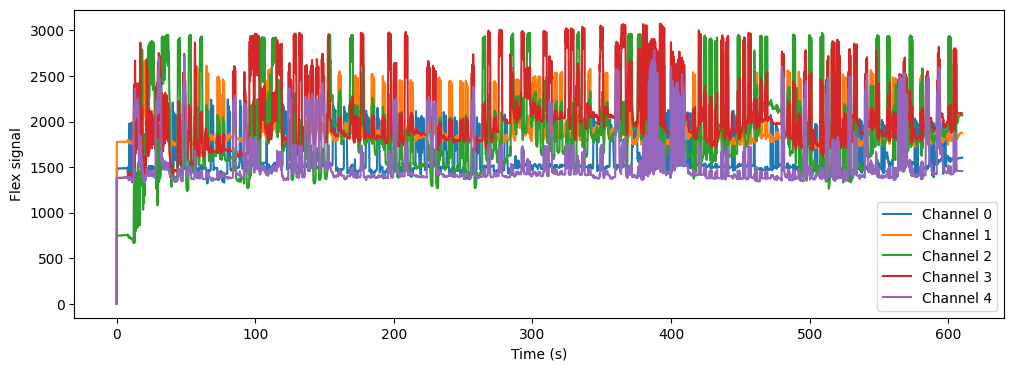

In [5]:
flex = data['flex']

# plot the raw data
plt.figure(figsize=(12, 4))
plt.plot(t, flex)
plt.xlabel('Time (s)')
plt.ylabel('Flex signal')
plt.legend(['Channel {}'.format(k) for k in np.arange(flex.shape[1])])
plt.show()


Well this is hard to read, but a few things stand out. First, the signals show different offsets, so we probably want to remove the mean. The baseline for channels 1 and 2 are higher than 0 and 4.  Also note that the range of values for the signals tend to differ. Channels 1 and 0 seem to have shorter deflections than the other ones. A simple way to make all the baselines equivalent and rescale the deflections is to *z-score* each signal. To z-score a signal, we subtract from it its mean and then divide by its standard deviation. This can be expressed mathematically as:

$$ zscore = \frac{X-E[X]}{SD[X]} $$

Here X is the signal, $E[X]$ is its mean, and $SD[X]$ is the standard deviation. Z-scoring transforms the data so that the value at each time point is now in terms of standard deviations from the mean. Generally that means that extreme values, such as the deflections we see, will not exceed a value of 5 (5 standard deviations from the mean).

We can implement this as a function using numpy functions. Then we can apply it to our flexion data.

In [6]:
# create zscore function with dimension parameter
def zscore(x, axis=None):
    return (x - np.mean(x, axis=axis, keepdims=True))/np.std(x, axis=axis, keepdims=True)

# zscore the data
zflex = zscore(flex, axis=0)

To visualize multichanel data, it is usually a good to separate out the channels along the y-axis, so that they do not overlap. Since the signals are z-scored, we can set a separation of 5 standard deviations between each trace.

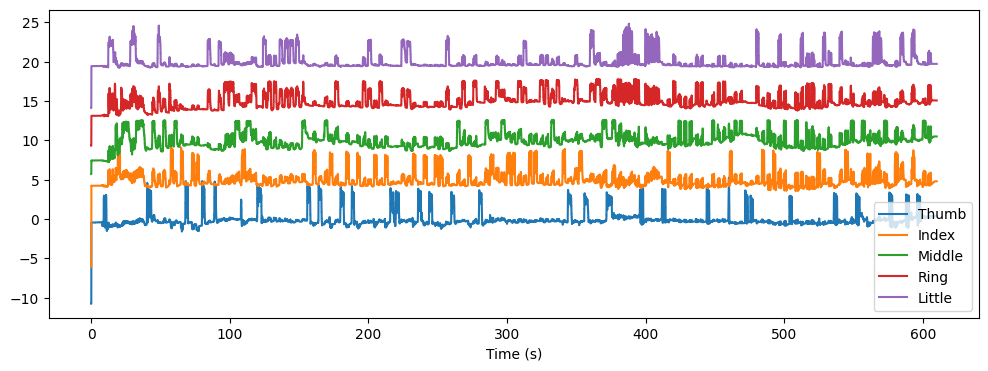

In [7]:
def plot_stacked_signals(sig, t, sep=5, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    for i in range(sig.shape[1]):
        ax.plot(t, sig[:, i] + i*sep, **kwargs)
    ax.set_xlabel('Time (s)')
    ax.legend()
    return ax

plt.figure(figsize=(12, 4))
plot_stacked_signals(zflex, t)
plt.legend(['Thumb', 'Index', 'Middle', 'Ring', 'Little'])

The signals looks fairly equalized now. We can see that for channel 0, the thumb, there is a well defined deflection with consistent height. The is also mostly true for the little finger, on channel 4. This is less the case for the index finger, which is showing modest deflections that are associated with deflections of either the middle or ring fingers. This means decoding flexion of the middle and ring fingers would prove difficult, since we cannot adequately isolate them. Instead, we will focus on the thumb, index, and little fingers.

To detect flexions, we need to set a threshold. Again, plotting the signals will help with this. Let's now plot just the fingers we intend to decode, and in a smaller time window so we can see how the signal fluctuates during deflections.

In [8]:
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Now we can see things more clearly. Each flexion event is actually a quick series of flexions, usually 3 in a row. It is that period we want to detect. The simplest way to do this is to set a threshold. We can then plot the detection signals overtop the flexion traces. 

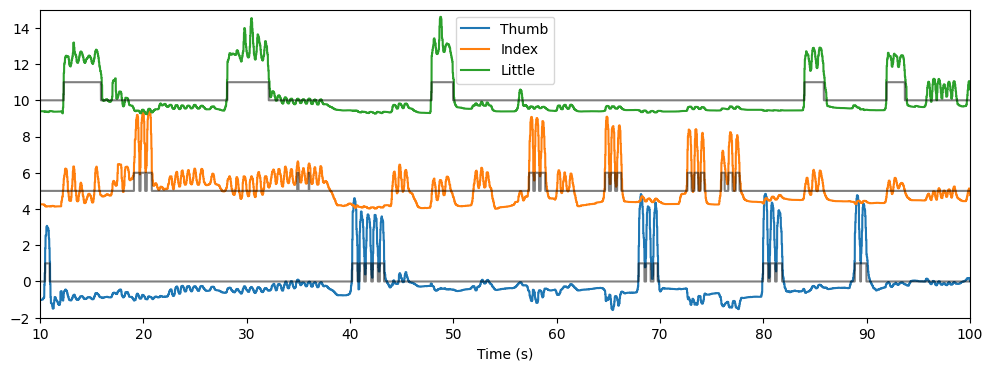

In [9]:
dflex = zflex>1.5

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

The detected flexion signals are transparent black lines layered on top the flexion traces. These seem to be pretty good except for two issues. First, during a flexion burst there are periods where the signal drops below the threshold, so we want to eliminate those gaps. Second, occasionally the index finger detection briefly occurs spuriously, for instance around 35 seconds. We can use *morphological binary operations* to fix these.

To remove gaps by grouping together closely spaced deflections we use the *morphological binary closing* operation. This fills in gaps between blocks of true values. Put another way, areas of 0s (bordered by 1s) that are smaller than a specified size are replaced with 1s. 

In [10]:
test_bin = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])
test_bin_close1 = sn.binary_closing(test_bin, structure=np.ones(1))
test_bin_close2 = sn.binary_closing(test_bin, structure=np.ones(2))
test_bin_close3 = sn.binary_closing(test_bin, structure=np.ones(3))

# print, right justified
print("test_bin:       {}".format(test_bin.astype(int)))
print("test_bin_close1:{}".format(test_bin_close1.astype(int)))
print("test_bin_close2:{}".format(test_bin_close2.astype(int)))
print("test_bin_close3:{}".format(test_bin_close3.astype(int)))

test_bin:       [0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_close1:[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_close2:[0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1]
test_bin_close3:[0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0]


The length of ones in the `structure` argument determines the maximum size allowed for a contiguous block of 0s. You can see that `structure=[1]` nothing changes. When `structure=[1,1]`, then any single 0s are removed. For a `structure=[1,1,1]` we remove blocks of 0s that are just two next to each other. The `structure` argument can be thought of as a filter for the binary data.

Let's apply it to the flexion time series. It should eliminate the gaps within a burst of finger flexions.

In [11]:
close_struct = np.ones([500,1]) # 500 ms, given the sampling rate of 1000 Hz
dflex_open = sn.binary_closing(dflex,close_struct)

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex_open[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Yay, we eliminated those gaps. 

Next, we will use a binary opening operation, which removes blocks with 1s shorter than a length specified by the `stucture` argument. You can think of a binary open operation as applying a filter to an array of binary data that sets to 0 (false) areas of 1s (trues) that are smaller than a preset size. For instance:

In [12]:
test_bin = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])
test_bin_open1 = sn.binary_opening(test_bin, structure=np.ones(1))
test_bin_open2 = sn.binary_opening(test_bin, structure=np.ones(2))
test_bin_open3 = sn.binary_opening(test_bin, structure=np.ones(3))

# print, right justified
print("test_bin:      {}".format(test_bin.astype(int)))
print("test_bin_open1:{}".format(test_bin_open1.astype(int)))
print("test_bin_open2:{}".format(test_bin_open2.astype(int)))
print("test_bin_open3:{}".format(test_bin_open3.astype(int)))

test_bin:      [0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_open1:[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1]
test_bin_open2:[0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]
test_bin_open3:[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]


For a 1d array, and if the filter is a list of 1s, then the length of the filter determines the minimum size allowed for a contiguous block of 1s. You can see that a filter of `[1]` nothing changes. When the filter is `[1,1]`, then any single 1s are removed. For a filter of `[1,1,1]` we remove blocks of 1s that are just two next to each other.

Let's apply it to the flexion data. Using this, we should be able to eliminate the spurious deflections on the index finger.

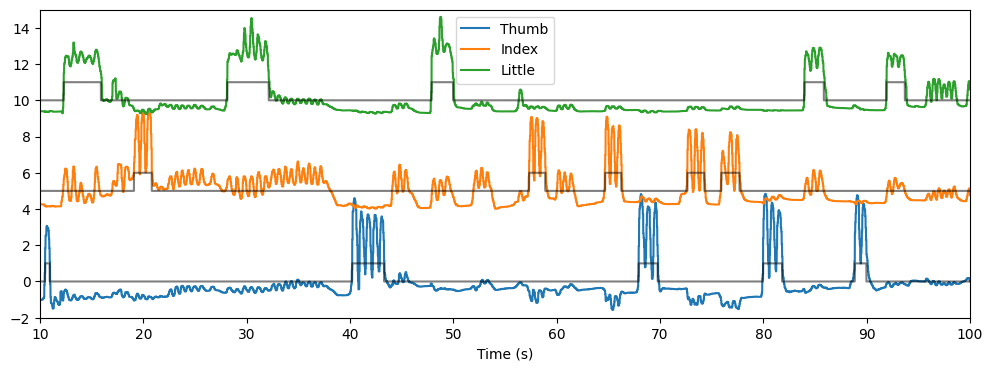

In [13]:
open_struct = np.ones([200,1]) # 200 ms, given the sampling rate of 1000 Hz
dflex_open_closed = sn.binary_opening(dflex_open,open_struct)

plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(dflex_open_closed[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([10, 100])
ax.legend(['Thumb', 'Index', 'Little'])

Looking good now! The periods of deflections are contiguous and we have eliminated spurious ones. Let's package all of this into a function that accepts flexion data and returns the series of detected deflections.

In [14]:
def detect_flex_events(sig, thresh=1.5, min_duration=200, max_spacing=500):
    """
    Detects events in a flex signal.
    
    Parameters
    ----------
    flex_sig : array_like
        The flex signal to detect events in.
    thresh : float
        The threshold to use for event detection.
    min_duration : int
        The minimum duration of an event (in samples).
    max_spacing : int
        The maximum spacing between events (in samples).
        
    Returns
    -------
    events : array_like
        Binary array.
    """
    # 1. get the z-scored flex signal
    z_sig = zscore(sig, axis=0)

    # 2. detect when signal crosses a threshold
    events = z_sig > thresh

    # 3. combine events spaced too closely together
    events = sn.binary_closing(events, structure=np.ones([max_spacing,1]))

    # 4. remove events shorter than min duration
    events = sn.binary_opening(events, structure=np.ones([min_duration,1]))
    
    return events.astype(int) # convert to int for numpy operations

# detect events
flex_events = detect_flex_events(flex)

# plot the events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])

Plotting a different time window, we can see that the index and little fingers occasionally share the same deflection periods, especially between 580 and 600 s. To minimize that, we can try raising the threshold a little.

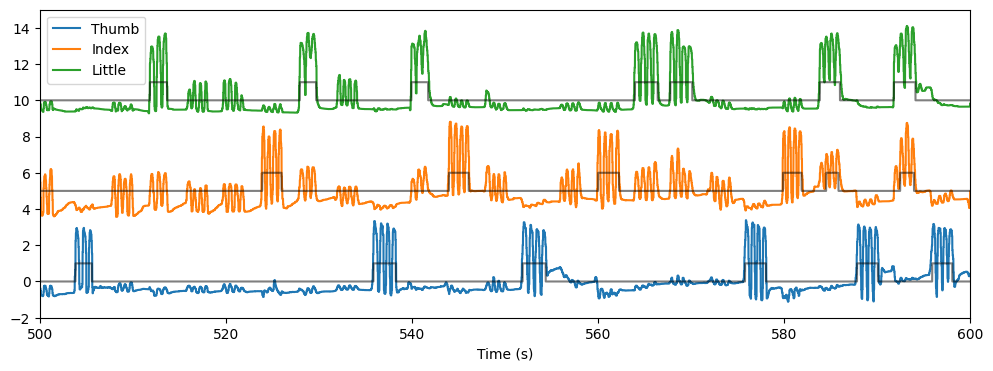

In [15]:
# detect events
flex_events = detect_flex_events(flex, thresh = 2)

# plot the events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])

Tweaking the detection parameters didn't fix it. Instead, we can add a final step to the algorithm that for overlapping finger detection times selects the finger with the highest amount of flexion.

In [16]:
def detect_flex_events(sig, thresh=1.5, min_duration=200, max_spacing=500):
    """
    Detects events in a flex signal.
    
    Parameters
    ----------
    flex_sig : array_like
        The flex signal to detect events in.
    thresh : float
        The threshold to use for event detection.
    min_duration : int
        The minimum duration of an event (in samples).
    max_spacing : int
        The maximum spacing between events (in samples).
        
    Returns
    -------
    events : array_like
        Binary array.
    """
    # 1. get the z-scored flex signal
    z_sig = zscore(sig, axis=0)

    # 2. detect when signal crosses a threshold
    events = z_sig > thresh

    # 3. combine events spaced too closely together
    events = sn.binary_closing(events, structure=np.ones([max_spacing,1]))

    # 4. remove events shorter than min duration
    events = sn.binary_opening(events, structure=np.ones([min_duration,1]))

    # 5. for each flexion epoch, keep only the channel with the largest amplitude
    epochs = np.any(events, axis=1).astype(int) # detect when any flexion happened
    epochs = np.concatenate(([0], epochs, [0])) # pad with False to detect onsets and offsets 
                                                # of the first and last epochs
    onsets = np.where(np.diff(epochs) == 1)[0] - 1 # detect transition from 0 to 1, 
                                                   # minus 1 to account for padding 
    offsets = np.where(np.diff(epochs) == -1)[0] - 1 # detect transition from 1 to 0

    for onset, offset in zip(onsets, offsets): # loop through each flexion epoch
        max_chan = np.argmax(np.max(z_sig[onset:offset,:], axis=0)) # find the channel with the largest amplitude
        events[onset:offset, :] = False # zero out all channels
        events[onset:offset, max_chan] = True # keep only the channel with the largest amplitude

    return events.astype(int) # convert to int for numpy operations

In [17]:
# detect events
flex_events = detect_flex_events(flex, thresh = 2)

thumb_starts = np.where(np.diff(flex_events[:, 0]) == 1)[0] + 1
index_starts = np.where(np.diff(flex_events[:, 1]) == 1)[0] + 1
little_starts = np.where(np.diff(flex_events[:, 4]) == 1)[0] + 1

# plot the start events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex[:, [0,1,4]],t)
plot_stacked_signals(flex_events[:, [0,1,4]],t, ax=ax, color='k', alpha=0.5)
ax.plot(t[thumb_starts], flex_events[thumb_starts, 0], 'r.')
ax.plot(t[index_starts], flex_events[index_starts, 1]+5, 'r.')
ax.plot(t[little_starts], flex_events[little_starts, 4]+10, 'r.')
ax.set_ylim([-2, 15])
ax.set_xlim([500, 600])
ax.legend(['Thumb', 'Index', 'Little'])



Our modification fixed the problem. We also marked the onset of finger flexion periods on the graph with a red dot. It it those flexion onsets that we will be analyzing.

So from here out we will use the `flex_events` time series to determine where finger movements occured.

Now that we can detect the times when finger deflections start, we want to identify which electrodes have activities associated with them. To start, we will look for ERPs, similar to how we did in previous weeks. We will trigger these off the start times of each finger flexion burst.

## ECoG responses to finger flexion
Let's visualize the ECoG signal, to see if we have to do any preprocessing on it. Recall that for the EEG signal we had to remove a slow basline drift, EMG, 60 Hz noise, and EOG. Do these artifacts occur in the new data set? We will peak at the first 10 channels to see.

In [18]:
ecog = data['data']

# plot ecog signal
plt.figure(figsize=(12, 4))
plot_stacked_signals(ecog[:,:10], t, sep=16000)
plt.legend(['Channel {}'.format(k) for k in np.arange(10)])

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Thankfully, there is no obvious drift here, so we don't need to remove that. There are some sharp deflections on channels 4 and 5, but they are not shared with other electrodes so it is unlikely that they reflect electro-oculogram artifacts. Perhaps 60 Hz noise is present. It is hard to see when viewing the entire recording session, so let's zoom in.

In [19]:
# plot ecog signal
plt.figure(figsize=(12, 4))
plot_stacked_signals(ecog[:,:10], t, sep=8000)
plt.legend(['Channel {}'.format(k) for k in np.arange(10)])
plt.xlim([500, 502])

(500.0, 502.0)

No obvious 60 Hz noise here. In fact, this data has already been preprocessed to remove it. As for EMG, we will not attempt to filter that out because subsequent analyses will depend on neural signals above 60 Hz, which was the cutoff we used for removing EMG data in our EEG dataset.

Working with the signal as is, let's get the ERP on each electrode in response to finger deflections.

In [20]:
def calc_ecog_erp(sig, events, pre=1.5, post=1.5):
    """
    Calculates the ERP for a given signal and set of events.
    
    Parameters
    ----------
    sig : array_like
        The signal to calculate the ERP for.
    events : array_like
        The events to calculate the ERP for.
    pre : float
        The time (in seconds) before the event to include in the ERP.
    post : float
        The time (in seconds) after the event to include in the ERP.
    
    Returns
    -------
    erp : array_like
        The ERP.
    t : array_like
        The time vector for the ERP.
    """

    # convert pre and post to samples
    pre = int(1.5*fs)
    post = int(1.5*fs)
    t = np.linspace(-pre, post, pre+post)

    # get epochs
    erp = []
    for i, o in enumerate(events):
        erp.append(sig[(o-pre):(o+post), :])

    # stack epochs and average
    erp = np.stack(erp, axis=2)
    erp = np.mean(erp, axis=2)

    return erp, t/fs

# calculate the ERPs
erp_thumb, t_erp = calc_ecog_erp(ecog, thumb_starts)
erp_index, _ = calc_ecog_erp(ecog, index_starts)
erp_little, _ = calc_ecog_erp(ecog, little_starts)

# plot the ERPs
fig, ax = plt.subplots(1, 3, figsize=(5, 7)) 
ax[0].pcolormesh(t_erp, ch, erp_thumb.T)
ax[0].set_title('Thumb')
ax[1].pcolormesh(t_erp, ch, erp_index.T)
ax[1].set_title('Index')
ax[2].pcolormesh(t_erp, ch, erp_little.T)
ax[2].set_title('Little')
fig.suptitle('ERP')
fig.supxlabel('Time (s)')
fig.supylabel('Channel')
fig.tight_layout()
plt.show()

Well that is interesting, it appears that we have a consistent set of channels that are activated across fingers. Notice that the pattern appears to repeat across channels. This might reflect the grid pattern of the ECoG array, with a cluster of sites near each other showing the strongest activation.

In [21]:
# plot locs colored by erp
def erp_grid(locs, erp, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(locs[:, 0], locs[:, 1], c=erp[t,:], cmap='coolwarm', s=100)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return ax

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
erp_grid(locs, erp_thumb, 1500, ax=ax[0])
ax[0].set_title('Thumb')
erp_grid(locs, erp_index, 1500, ax=ax[1])
ax[1].set_title('Index')
erp_grid(locs, erp_little, 1500, ax=ax[2])
ax[2].set_title('Little')
fig.suptitle('ERP voltage at 0 s')
fig.tight_layout()

Broadly the same pattern is present across the grid for the ERP in response to different finger movements. But, there are some subtle differences which can be exploited down the line by feeding multiple channels into our decoder. 

To get a better grasp of the activity, let's plot the ERP from the channel with a strong negative deflection.

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(t_erp, erp_thumb[:, 20])
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Thumb ERP at channel 20')

Text(0.5, 1.0, 'Thumb ERP at channel 20')

Notice that at the trough of this ERP, we see a burst of high frequency activity, as we did in our simulations in week 1 that we returned to above. To analyze this signal, we will now turn to spectral analysis. It might be easiest to start by showing the end point of this analysis, and then working towards it for the rest of this lecture. 

We will calculate the *spectrogram* of our ECoG signal, which takes a time series and breaks it apart into separate frequency bands with varying amplitude across time. Then, just as with the ERP, we can calculate the mean spectral response centered on a finger movement. Let's do this for channel 20.

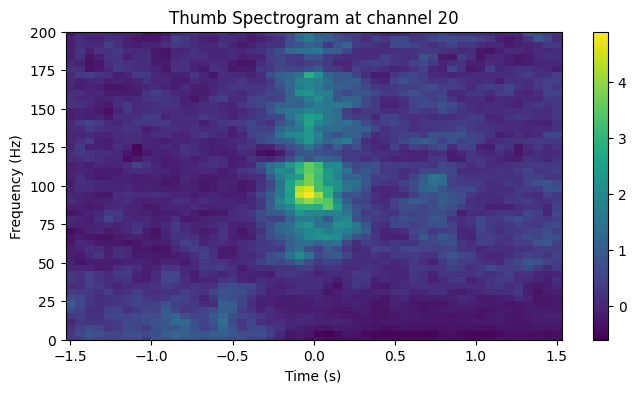

In [23]:
# calculate spectrogram
freqs, t_spec, s = spectrogram(ecog[:, 20], fs, nperseg=256, noverlap=200, window='hann')
fs_spec = 1/np.mean(np.diff(t_spec))

# zscore the spectrogram so all frequencies are on the same scale
s = zscore(s, 1)

# create a new array of flexion events at the time points closest to those in the spectrogram data
thumb_starts_spec = np.zeros(thumb_starts.shape).astype(int)

for i,t in enumerate(thumb_starts/fs):
    thumb_starts_spec[i] = np.argmin(np.abs(t_spec-t))

# calculate the mean spectrogram for thumb events
pre = int(1.5*fs_spec)
post = int(1.5*fs_spec)
thumb_spec = []
for i, o in enumerate(thumb_starts_spec):
    thumb_spec.append(s[:, o-pre:o+post])
thumb_spec = np.stack(thumb_spec, axis=2)
thumb_spec_mean = np.mean(thumb_spec, axis=2)

# plot the spectrogram
t_spec_win = np.linspace(-1.5, 1.5, pre+post)
plt.figure(figsize=(8, 4))
plt.pcolormesh(t_spec_win, freqs, thumb_spec_mean)
plt.ylim([0, 200])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Thumb Spectrogram at channel 20')
plt.colorbar()

Notice the bright spot right before the thumb movement onset, and at frequencies between 50 and 150 Hz. This high frequency activity reflects activity in the cortex immediately below the electrode, a combination of spiking and locally generated fast oscillations. Numerous studies have found this high frequency activity when movements are initiated. In addition, you may notice a coincident decrease in low frequency activity, below 25 Hz. That too is a well established neural correlate of movement, known as *event-related desynchronization*. 

These high frequency bursts are even evident on individual trials.

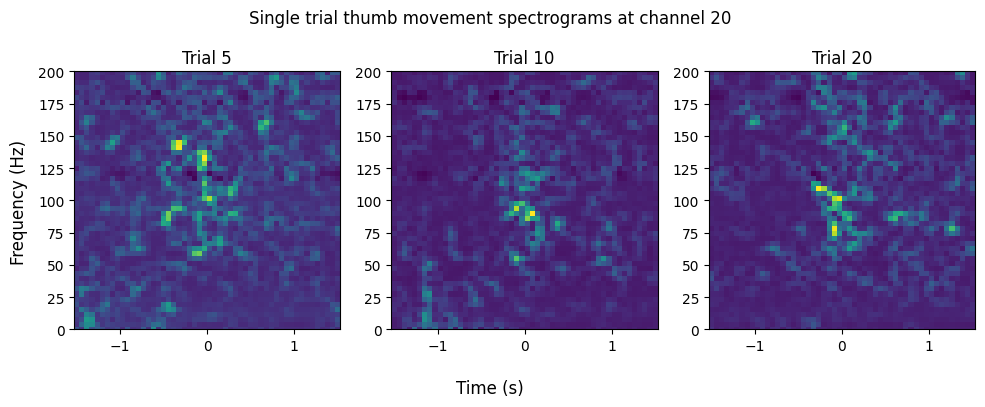

In [24]:
# plot individual trials
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, ind in enumerate([5, 10, 20]):
    ax[i].pcolormesh(t_spec_win, freqs, thumb_spec[:,:,ind])
    ax[i].set_ylim([0, 200])
    ax[i].set_title('Trial {}'.format(ind))
fig.suptitle('Single trial thumb movement spectrograms at channel 20')
fig.supxlabel('Time (s)')
fig.supylabel('Frequency (Hz)')
fig.tight_layout()


The high frequency bursts occur as strong, but sporadic, events that cluster around movement onset. 

Now that we know what we want to detect, let's go over the basics of spectral analysis so you understand where they come from.

## Spectral analysis basics

The starting point of spectral analysis is the fact that any signal can be broken down into a sum of sinusoidal waves. To refresh, a sinusoid is a periodic function that flucuates between positive and negative peaks, repeating itself over and over every $2\pi$ steps along the x-axis.

Text(0.5, 1.0, 'Sinusoid')

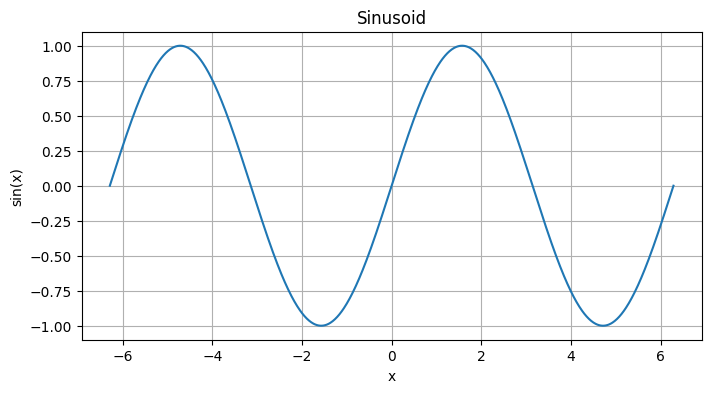

In [25]:
# plot a sinusoid
plt.figure(figsize=(8, 4))
x = np.linspace(-2*np.pi, 2*np.pi, 1000)
plt.plot(x, np.sin(x))
plt.grid()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Sinusoid')

We can modify a sinusoid wave in three ways, illusrated by the following equation:

$$ y = Asin(fx2\pi+p) $$

$A$ controls the *amplitude*, allowing the sine wave to peak at values greater or less than 1/-1. Next is $f$, which controls the frequency. The frequency determines how many cycles of the wave occur per a step of 1 along the x-axis. To get the increments in terms of steps of 1, we multiply $x$ by $2\pi$. Last is $p$, which shifts the sinusoid forward or backward. It is also known as the phase offset. See the visualizations of these three parameters.

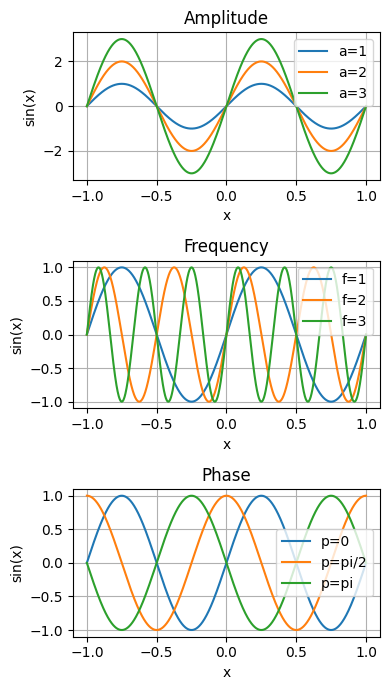

In [26]:
sin_func = lambda x,a,f,p : a*np.sin(2*np.pi*f*x + p)
x = np.linspace(-1, 1, 1000)
# Create 3 subplots, each with 3 different sine waves where one parameter is varied. The first subplot will be amplitude, second will be frequency, and third will be phase.
fig, ax = plt.subplots(3, 1, figsize=(4, 7))
ax[0].plot(x, sin_func(x, 1, 1, 0))
ax[0].plot(x, sin_func(x, 2, 1, 0))
ax[0].plot(x, sin_func(x, 3, 1, 0))
ax[0].set_xlabel('x')
ax[0].set_ylabel('sin(x)')
ax[0].set_title('Amplitude')
ax[0].legend(['a=1', 'a=2', 'a=3'])
ax[0].grid()
ax[1].plot(x, sin_func(x, 1, 1, 0))
ax[1].plot(x, sin_func(x, 1, 2, 0))
ax[1].plot(x, sin_func(x, 1, 3, 0))
ax[1].set_xlabel('x')
ax[1].set_ylabel('sin(x)')
ax[1].set_title('Frequency')
ax[1].legend(['f=1', 'f=2', 'f=3'])
ax[1].grid()
ax[2].plot(x, sin_func(x, 1, 1, 0))
ax[2].plot(x, sin_func(x, 1, 1, np.pi/2))
ax[2].plot(x, sin_func(x, 1, 1, np.pi))
ax[2].set_xlabel('x')
ax[2].set_ylabel('sin(x)')
ax[2].set_title('Phase')
ax[2].legend(['p=0', 'p=pi/2', 'p=pi'])
ax[2].grid()
fig.tight_layout()

Recall how we identified the degree of fit between the EEG and the ERP by convolving them (taking their dot product). We can measure the degree to which a signal contains a reference sine wave at a specific frequency by convolving it with the signal. Below we create a reference sine with a frequency of 1 and phase offset of 0, and explore its dot products with sine wave signals that vary in their amplitude, frequency, and phase offset. We will refer to this dot product as $a$:

$$ b = y \cdot sin(2\pi ft) $$

where $y$ is the signal we are assessing for the presence of the sine wave.

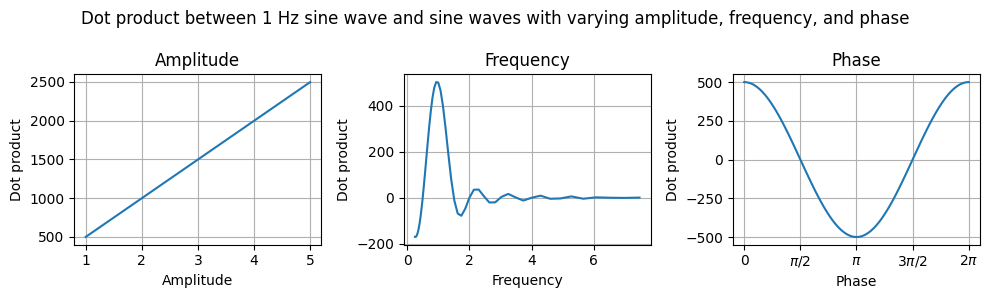

In [27]:
# quantify the dot product between a 1 Hz sine wave and: 
x = np.linspace(0, 1, 1000)
ref_sin = sin_func(x, 1, 1, 0) # 1 Hz sine wave

# 1. amplitude
var_a = [np.dot(ref_sin, sin_func(x, a, 1, 0)) for a in range(1, 6)] # vary amplitude
var_f = [np.dot(ref_sin, sin_func(x, 1, f, 0)) for f in np.power(2.0, np.arange(-2, 3, 0.1))] # vary frequency
var_p = [np.dot(ref_sin, sin_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)] # vary phase

# plot the dot products
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(range(1, 6), var_a)
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Dot product')
ax[0].set_title('Amplitude')
ax[0].grid()
ax[1].plot(np.power(2.0, np.arange(-2, 3, 0.1)), var_f)
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Dot product')
ax[1].set_title('Frequency')
ax[1].grid()
ax[2].plot(np.linspace(0, 2*np.pi, 100), var_p)
ax[2].set_xticks(np.linspace(0, 2*np.pi, 5))
ax[2].set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax[2].set_yticks(np.arange(-500, 501, 250))
ax[2].set_xlabel('Phase')
ax[2].set_ylabel('Dot product')
ax[2].set_title('Phase')
ax[2].grid()
fig.suptitle('Dot product between 1 Hz sine wave and sine waves with varying amplitude, frequency, and phase')
fig.tight_layout()


As we increase the amplitude, the dot product increases. This is because as the signal amplitude increases, the dot product increases by the same factor. If you double the amplitude, then the dot product will double.

For frequency, the the dot product peaks when the signal frequency is the same as the sine wave we convolved it with, and fluctuates towards zero as the difference between the frequencies increases. When the sine wave and signal frequency are the same, the positive phases and negatives of the sine waves align, and so when they are multiplied together one always gets a positive value, yielding a large dot product. On the other hand, if the frequencies are vary different, then there will be an equal number of periods when the positive and negative phases align, along with periods when they are misaligned. These cancel each other out, leading to a sum of 1. For frequencies that are nearby, there may be a bias to more aligned or misaligned periods, leading to the fluctuations at frequencies near our reference sine wave.

Lastly, when the signal and reference have the same frequency, but the phase is varied, we see a systematic fluctuation in the dot product. It peaks when the phase offset is at 0 or $2\pi$, is most negative at $\pi$, and zero at $\pi/2$ and $3\pi/2$. This reflects the shifting overlap of the positive and negative phases of the sine wave. At 0 and $2\pi$ the phases align perfectly, so they add constructively. When the phase offset is at $\pi$ the positive peaks of the reference always overlap with the negative peaks of the signal, and vice versa, meaning that only negative values are returned when they are multiplied together for the dot product. In between those phases, the degree of overlap changes, with different degrees of overlap between positive and negative peaks. And lastly at $\pi/2$ and $3\pi/2$, there is an equal proportion of overlap for peaks of the same or different signs overlapping, which balances out and sums to 0.

In spectral analysis, we want to determine which frequencies are present in a signal, and at what amplitude and phase offset. Since the dot product varies with phase, sometimes even returning a 0, we need to find a way to detect a sine wave when its phase is offset by $\pi/2$. If we shift the sine wave by that amount, we should be able to detect it. A sine wave shifted by $\pi/2$ is a cosine wave. So, we will create a new function for that.

$$ a = y \cdot cos(2\pi ft) $$


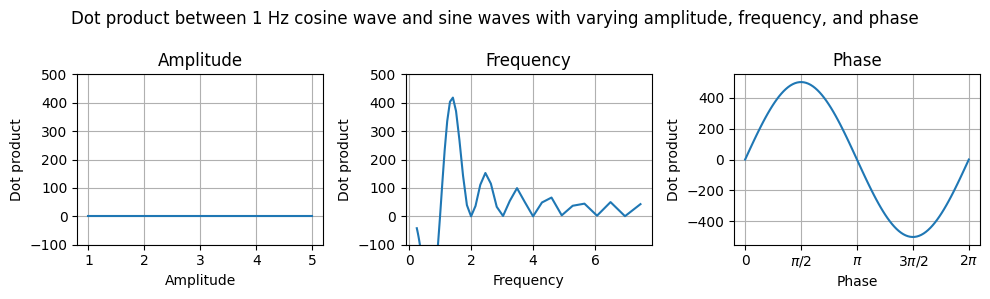

In [28]:
cos_func = lambda x,a,f,p : a*np.cos(2*np.pi*f*x + p)
ref_cos = cos_func(x, 1, 1, 0) # 1 Hz cosine wave

var_a = [np.dot(ref_cos, sin_func(x, a, 1, 0)) for a in range(1, 6)]
var_f = [np.dot(ref_cos, sin_func(x, 1, f, 0)) for f in np.power(2.0, np.arange(-2, 3, 0.1))]
var_p = [np.dot(ref_cos, sin_func(x, 1, 1, p)) for p in np.linspace(0, 2*np.pi, 100)]

# plot the dot products
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(range(1, 6), var_a)
ax[0].set_ylim([-100, 500])
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Dot product')
ax[0].set_title('Amplitude')
ax[0].grid()
ax[1].plot(np.power(2.0, np.arange(-2, 3, 0.1)), var_f)
ax[1].set_ylim([-100, 500])
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Dot product')
ax[1].set_title('Frequency')
ax[1].grid()
ax[2].plot(np.linspace(0, 2*np.pi, 100), var_p)
ax[2].set_xticks(np.linspace(0, 2*np.pi, 5))
ax[2].set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
#ax[2].set_yticks(np.arange(-500, 501, 250))
ax[2].set_xlabel('Phase')
ax[2].set_ylabel('Dot product')
ax[2].set_title('Phase')
ax[2].grid()
fig.suptitle('Dot product between 1 Hz cosine wave and sine waves with varying amplitude, frequency, and phase')
fig.tight_layout()

Inspecting the phase plot, we can now detect when the signal sine wave is offset by $\pi/2$, but we still have the problem with dot products with a value of 0, just now at multiples of $\pi$. Since all our signals had an offset of 0, this means none of them are detectable with a cosine wave. This is evident in the Amplitude and Frequency plots, which are all zeros. 

If we want to detect whether a sine wave is present, irrespective of its phase offset, we need to combine the sine and cosine dot products. Instead of keeping these ($a$ and $b$) seperate for each frequency, we combine these into a single *complex number*. To briefly refresh, complex numbers have two components, a real part that lies along the x-axis, and an imaginary component that lies along the y-axis. The $a$ component associated with the cosine is the real part, and the $b$ component associated with sine is the imaginary component.

To get of sense of how to combine these, let's redo the phase plot, but this time have the dot product for sin plotted on the y-axis, and cosine on the x-axis.

<Axes: xlabel='Cosine (real)', ylabel='Sine (imaginary)'>

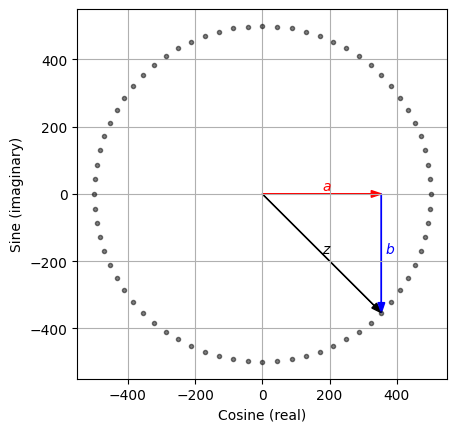

In [29]:
# vary the phase of the signal and calculate its dot product with the sine and cosine reference signals
ph_arr = np.pi*np.arange(0,360,5)/180
var_p_sin = [np.dot(ref_sin, cos_func(x, 1, 1, p)) for p in ph_arr]
var_p_cos = [np.dot(ref_cos, cos_func(x, 1, 1, p)) for p in ph_arr]

var_p_cpx = np.array([complex(a,b) for a,b in zip(var_p_cos, var_p_sin)])


disp_p = np.abs(ph_arr - np.pi/4).argmin()

def plot_complex(z, sel_ind=0, lbl_sel='$z$', ax=None):
    if ax is None:
        ax = plt.gca()
    
    sel_z = z[sel_ind]
    arrow_params = {'width':0.05, 'head_width':20, 'length_includes_head':True}

    # plot all the complex numbers
    ax.plot(z.real, z.imag, 'k.', alpha=0.5)

    # plot arrow for the selected complex number
    ax.arrow(0, 0, sel_z.real, sel_z.imag, color='k', **arrow_params)
    ax.text(sel_z.real/2, sel_z.imag/2, lbl_sel, fontsize=10, color='k')

    # plot arrow for the selected real component
    ax.arrow(0, 0, sel_z.real, 0, color='r', **arrow_params)
    ax.text(sel_z.real/2, 10, '$a$', fontsize=10, color='r')

    # plot arrow for the selected imaginary component
    ax.arrow(sel_z.real, 0, 0, sel_z.imag, color='b', **arrow_params)
    ax.text(sel_z.real+10, sel_z.imag/2, '$b$', fontsize=10, color='b')
    ax.set_xlabel('Cosine (real)')
    ax.set_ylabel('Sine (imaginary)')
    ax.grid()
    ax.set_aspect('equal')
    return ax

plot_complex(var_p_cpx, sel_ind=disp_p)

Notice that a circle is drawn. The radius of that circle is constant, irrespective of the phase offset. Normally we will only be presenting one signal, so we cannot sample the full circle. But, if we know the dot product for the sine and cosine refernces, we can calculate it using the Euclidean distance:

$$ 
Amp = \sqrt{a^2 + b^2}
$$

For a complex number, $a$ and $b$ can be replaced with the real and imaginary components, respectively. The numpy function `abs`, when passed a complex number, calculates the Euclidean distance in this way. Let's see if this gives us a consistent answer.

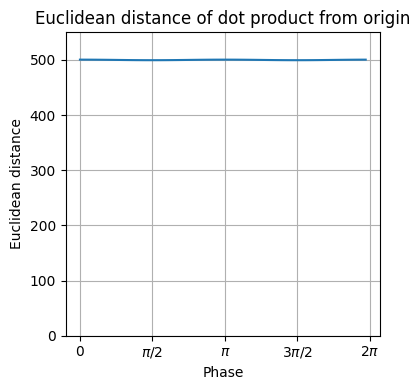

In [30]:
# calculate the euclidean distance of the dot products from the origin
dist = np.abs(var_p_cpx)
plt.figure(figsize=(4, 4))
plt.plot(ph_arr, dist)
plt.ylim([0, 550])
plt.xticks(np.linspace(0, 2*np.pi, 5), ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.grid()
plt.xlabel('Phase')
plt.ylabel('Euclidean distance')
plt.title('Euclidean distance of dot product from origin')
plt.tight_layout()

Great, so now we have a way to measure the amplitude of a sinusoidal wave irrespective of its phase. The next thing we want to measure with spectral analysis is the phase. This too can be derived from the $a$ and $b$ parameters. We measure the angle with respect to the x-axis using the `angle` function in numpy.

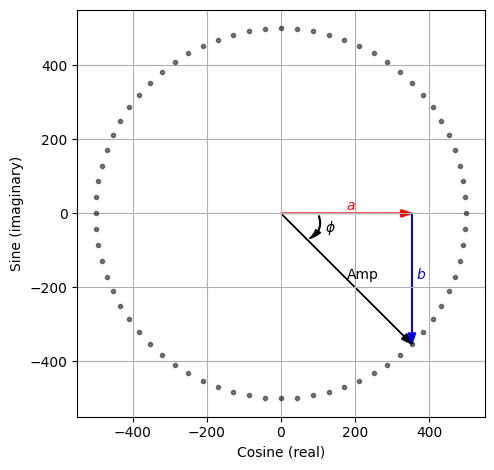

In [31]:
plot_complex(var_p_cpx, sel_ind=disp_p, lbl_sel='Amp')
# draw curved arrow at the angle of the dot product
arrow = FancyArrowPatch((100, 0), (var_p_cpx[disp_p].real/5, var_p_cpx[disp_p].imag/5), arrowstyle='Simple,tail_width=0.5,head_width=4,head_length=8', color='k', connectionstyle='arc3,rad=-.5')
# label arrow with the phase
plt.text(120, -50, '$\phi$', fontsize=10, color='k')
plt.gca().add_patch(arrow)
plt.tight_layout()

Let' calculate the angle now. The numpy `angle` function takes a complex number (which corresponds to the black arrow in the above graph), and returns its angle with respect to a line on the x-axis pointing to the right.

In [32]:
var_p_ang = np.angle(var_p_cpx)

var_p_45 = var_p_ang[disp_p]
print("Phase of dot product: {:.0f} degrees".format(np.round(180*(var_p_45/np.pi))))

Phase of dot product: -45 degrees


-45 degrees? Strange, we had phase shifted the sine wave to be at +45 degrees (pi/4 = 45 degrees). Let's plot the relationship between the phase derived from $a$ and $b$ and the actual phase.

Text(0, 0.5, 'Calculated phase (rad)')

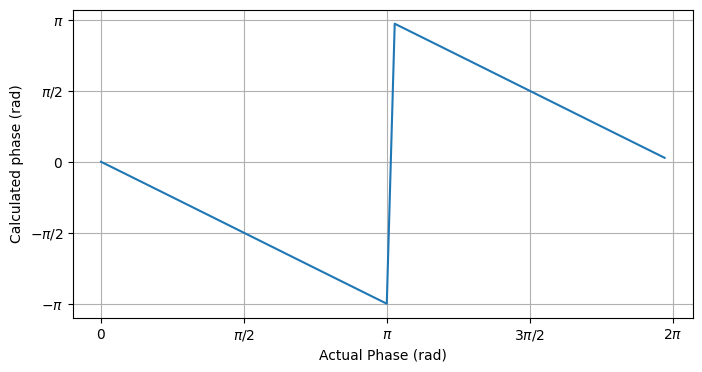

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(ph_arr, var_p_ang)
plt.xticks(np.linspace(0, 2*np.pi, 5), ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.yticks(np.linspace(-np.pi, np.pi, 5), ['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
plt.grid()
plt.xlabel('Actual Phase (rad)')
plt.ylabel('Calculated phase (rad)')


It appears that the sign is wrong. As we increase the actual phase from 0 to $\pi$ (180 degrees), the angle matches the magnitude, but is negative instead of positive. Once we go past $\pi$, the angle flips. To fix this, we can negate the sine (imaginary) component.

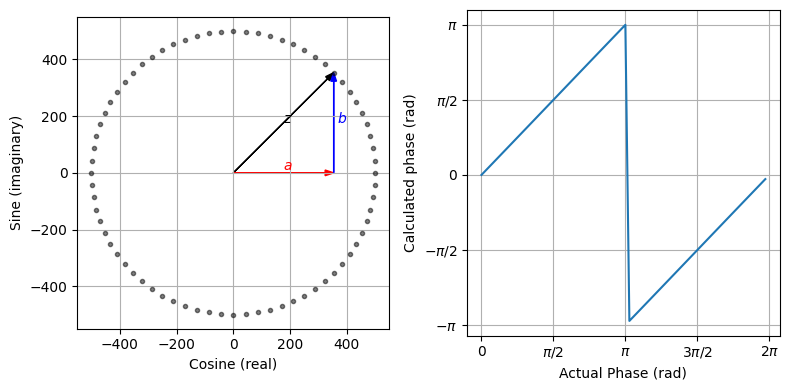

In [34]:
var_p_cpx = np.array([complex(a,-b) for a,b in zip(var_p_cos, var_p_sin)])
var_p_ang = np.angle(var_p_cpx)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_complex(var_p_cpx, sel_ind=disp_p, ax=ax[0])
ax[1].plot(ph_arr, var_p_ang)
ax[1].set_xticks(np.linspace(0, 2*np.pi, 5), ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax[1].set_yticks(np.linspace(-np.pi, np.pi, 5), ['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
ax[1].grid()
ax[1].set_xlabel('Actual Phase (rad)')
ax[1].set_ylabel('Calculated phase (rad)')
fig.tight_layout()


That fixed the phase problem.

So far we have done this for just a single reference frequency. But signals we record in the brain can be decomposed into multiple sinusoids.

The Fourier transform achieves this. It takes a signal varying across time and translates it into the frequency domain, representing a sum of sine waves across frequencies each with a particular amplitude and phase offset. Put another way, we can describe a time series $y(t)$ as a series of real values at different times $t$, $[y_0, y_1, y_2, ..., y_n]$, where $n$ is the number of time points. The frequency domain representation of that signal, $Y(f)$, is a series of complex values at different frequencies, $[Y_0, Y_1, Y_2, ..., Y_n]$, where n is the number of frequencies. Since we are dealing with digitized signals that are sampled at a fixed rate and for a finite amount of time, we will use the *discrete Fourier transformation* (DFT). The DFT can be written as:

$$ \begin{align}
    \notag Y(f) &= a - bi \\
    \notag Y(f) &= y \cdot cos(2\pi f t) - y \cdot sin(2\pi f t)i \\
    \notag Y(f) &= \sum_{t=0}^{n}y(t)cos(2\pi f t) - y(t)sin(2\pi f t)i \\
    \end{align}
$$

We will refer to $Y(f)$ as a spectrum. The frequencies, $f$, that make up the spectrum are determined by the duration of the signal and sample rate. The minimum frequency we can measure is 0, which is just the mean value of the signal. We then increase from 0 in steps of $1/T$, where $T$ is the duration of the signal. To unambiguously measure the presence of a sinusoid, you need to have at least one full cycle of it. Thus, a sinusoid with a frequency of $1/T$ will have the smallest frequency that can be measured. We then increase the frequency in steps of $1/T$, for as many time points as there are in the signal. For instance, if we record a signal for 1 second, and sample at a rate of 1kHz, that gives us a frequency step of $1/1 sec = 1 Hz$. With 1000 samples, that means we have up to 1000 Hz. Let's try to code this.

In [35]:
# discrete fourier transform function
def dft(y, fs=1000):
    """
    Calculates the discrete fourier transform of a signal.
    
    Parameters
    ----------
    y : array_like
        The signal to calculate the DFT for.
    fs : float
        The sampling rate of the signal.
    
    Returns
    -------
    f : array_like
        The frequency vector.
    Y : array_like
        The DFT of the signal.
    """

    # get the length of the signal
    N = len(y)

    # frequencies are 
    f = (np.arange(N)/N)*fs
                    
    # initialize the DFT vector
    Y = np.zeros(N, dtype=complex)

    # create the time vector
    t = np.arange(N)/fs

    # calculate the DFT
    for k in range(N):
        Y[k] = complex(np.dot(y, np.cos(2*np.pi*f[k]*t)), np.dot(y, -np.sin(2*np.pi*f[k]*t)))
    return f, Y

# create test signals with different frequencies
dur = 1 # duration of signal in seconds
fs = 1000 # sampling rate in Hz
x = np.linspace(0, dur, dur*fs)
test_sin1 = sin_func(x, 1, 1, 0)
test_sin2 = sin_func(x, 1, 50, 0)
test_sin3 = sin_func(x, 1, 200, 0)

# calculate the DFT of the test signals
f, Y_sin1 = dft(test_sin1)
f, Y_sin2 = dft(test_sin2)
f, Y_sin3 = dft(test_sin3)

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f, np.abs(Y_sin1))
ax.plot(f, np.abs(Y_sin2))
ax.plot(f, np.abs(Y_sin3))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('DFT Magnitude')
ax.legend(['1 Hz', '50 Hz', '200 Hz'])
fig.tight_layout()

We can see that each spectrum shows a single peak at the frequency of the sine wave we created, either 1, 50, or 200 Hz. However, we also see that these are mirrored above 500 Hz. The DFT found an 800 Hz wave with the 200 Hz signal, a 950 Hz wave at the 50 Hz signal, and a 999 Hz signal with the 1 Hz signal. The reasons for this are a bit beyond this course, but put simply arise because sinusoids greater than one half of the sample rate (here 500 Hz) cannot be adequately identified and in fact can be spuriously detected. Thus, we usually cut off the spectrum at half the sample rate, commonly referred to as the Nyquist frequency.

What happens if we have multiple sine waves combined together for our signal?

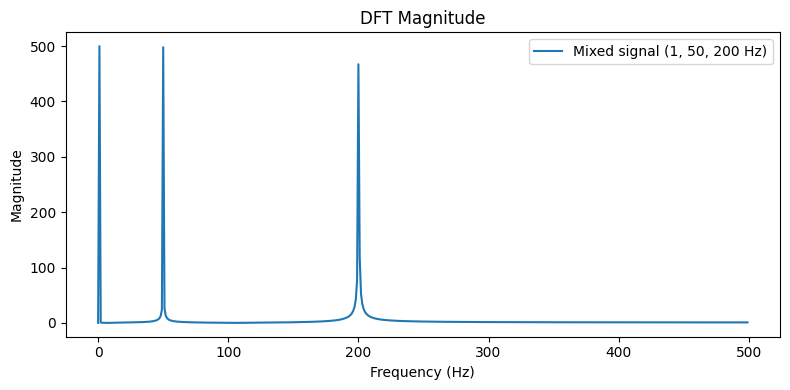

In [36]:
dur = 1 # duration of signal in seconds
fs = 1000 # sampling rate in Hz
x = np.linspace(0, dur, dur*fs)
test_sinmixed = sin_func(x, 1, 1, 0) + sin_func(x, 1, 50, 0) + sin_func(x, 1, 200, 0)

# calculate the DFT of the test signals
f, Y_sinmixed = dft(test_sinmixed)

nyq_ind = np.argmin(np.abs(f-fs/2))

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f[:nyq_ind], np.abs(Y_sinmixed[:nyq_ind]))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('DFT Magnitude')
ax.legend(['Mixed signal (1, 50, 200 Hz)'])
fig.tight_layout()


It works! Notice our spectral peaks are not single lines at the frequency we injected, but spread a bit to adjacent frequencies. When calculating the DFT, a sinusoid at frequency F will be similar enough to ones at frequencies near F that the finite length of the signal does not give enough time for them to fully cancel out. Consequently, if we increase the length of the signal, we should see less spread. Let's test this out.

(190.0, 210.0)

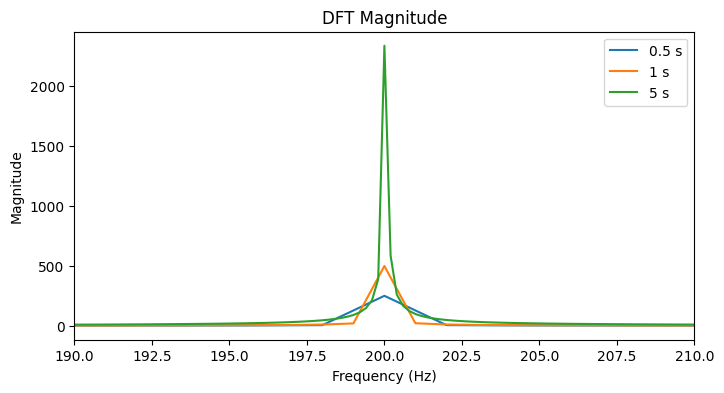

In [37]:
dur = 5 # duration of signal in seconds
x = np.linspace(0, dur, dur*fs)

test_sin_5 = sin_func(x, 1, 200, 0)

# calculate the DFT of the test signals sampling either 0.5, 1, or 5 seconds of the signal
f_05, Y_sin_05 = dft(test_sin_5[:int(0.5*fs)])
f_1, Y_sin_1 = dft(test_sin_5[:int(1*fs)])
f_5, Y_sin_5 = dft(test_sin_5[:int(5*fs)])

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f_05, np.abs(Y_sin_05), label='0.5 s')
ax.plot(f_1, np.abs(Y_sin_1), label='1 s')
ax.plot(f_5, np.abs(Y_sin_5), label='5 s')
#ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('DFT Magnitude')
ax.legend()
ax.set_xlim([190, 210])


Note how the sharpness of the spectral peak changes with the duration of our signal. The longer we sample, the more precisely we can estimate our spectral peak. This is because our frequency resolution increases, since the step between frequencies is 1/signal duration. 
An additional change with sample length is the DFT magnitude. The increase in magnitude is because we are adding additional data points to our dot product, so it grows in proportion to the signal duration. We can correct for this by dividing the spectral powers by the duration of the signal used to calculate them.

In [38]:
# replot spectra but now divided by the duration of the signals that were sampled
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f_05, np.abs(Y_sin_05)/0.5, label='0.5 s')
ax.plot(f_1, np.abs(Y_sin_1)/1, label='1 s')
ax.plot(f_5, np.abs(Y_sin_5)/5, label='5 s')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized magnitude')
ax.set_title('DFT Normalized magnitude, divided by signal duration')
ax.legend()
ax.set_xlim([190, 210])


(190.0, 210.0)

The DFT function we wrote was helpful for understanding how spectral analysis is performed, but it is not very efficient. There are faster implentations that exploit the fact that some calculations are repeated by the DFT, so they only need to be performed once. This algorithm is called the *fast Fourier transform* (FFT), and it is built in to Numpy. Let's use it to recalculate our spectra. First we call the `fft` function.

In [39]:
# use the fft function from numpy to recalculate the DFT
Y_sin_05_np = np.fft.fft(test_sin_5[:int(0.5*fs)])
Y_sin_1_np = np.fft.fft(test_sin_5[:int(1*fs)])
Y_sin_5_np = np.fft.fft(test_sin_5[:int(5*fs)])

# print the size and data type of the output of the fft function
print("0.5 duration signal has a size of {} and data type {}".format(Y_sin_05_np.shape, Y_sin_05_np.dtype))
print("1 duration signal has a size of {} and data type {}".format(Y_sin_1_np.shape, Y_sin_1_np.dtype))
print("5 duration signal has a size of {} and data type {}".format(Y_sin_5_np.shape, Y_sin_5_np.dtype))

0.5 duration signal has a size of (500,) and data type complex128
1 duration signal has a size of (1000,) and data type complex128
5 duration signal has a size of (5000,) and data type complex128


Just as with our DFT function, the spectrum is returned with a length equal to the signal we passed to it and in the form of a complex number. The numpy `fft` function does not return the frequencies, but it does provide a function for calculating that based on the signal length and sample rate.

In [40]:
# calculate the frequency vector
f_05_np = np.fft.fftfreq(len(Y_sin_05_np), 1/fs)
f_1_np = np.fft.fftfreq(len(Y_sin_1_np), 1/fs)
f_5_np = np.fft.fftfreq(len(Y_sin_5_np), 1/fs)

# plot the frequency vector and compare it with the one returned from the dft function
fig, ax = plt.subplots(2,1,figsize=(5, 4))
ax[0].plot(f_05)
ax[1].plot(f_05_np)
ax[0].set_title('Frequency vector returned by dft function')
ax[1].set_title('Frequency vector returned by fft function')
ax[0].grid()
ax[1].grid()
fig.supxlabel('Index')
fig.supylabel('Frequency (Hz)')
fig.tight_layout()

The outputs of our functions agree up till the Nyquist frequency, 500 Hz (index 250). After that, the `fftfreq` switches to giving the frequencies as negative. Representing frequencies this way is related to the complex values used to represent spectra, and becomes relevant when using the FFT on signals that are complex. Since the voltage signals we record and pass to the fft are real, we don't have to worry about these and will ignore them. We can now compare the output of our `DFT` function and numpy's `FFT`.

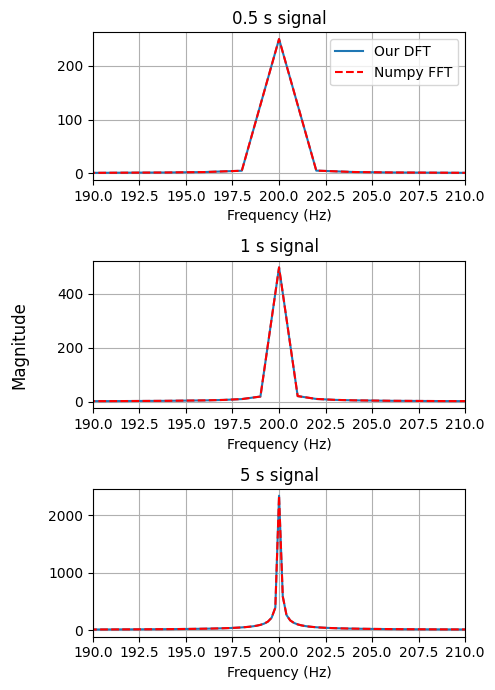

In [41]:
# For each of the signals, plot the DFT and numpy fft versions, with the numpy overlaid on the dft version as a dashed red line. Make sure to label the axes and include a legend.
nyq_ind_05 = np.argmin(np.abs(f_05-fs/2))
nyq_ind_1 = np.argmin(np.abs(f_1-fs/2))
nyq_ind_5 = np.argmin(np.abs(f_5-fs/2))
fig, ax = plt.subplots(3,1,figsize=(5, 7))
ax[0].plot(f_05[:nyq_ind_05], np.abs(Y_sin_05[:nyq_ind_05]), label='Our DFT')
ax[0].plot(f_05_np[:nyq_ind_05], np.abs(Y_sin_05_np[:nyq_ind_05]), '--r', label='Numpy FFT')
ax[0].set_title('0.5 s signal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_xlim([190, 210])
ax[0].legend()
ax[0].grid()
ax[1].plot(f_1[:nyq_ind_1], np.abs(Y_sin_1[:nyq_ind_1]))
ax[1].plot(f_1_np[:nyq_ind_1], np.abs(Y_sin_1_np[:nyq_ind_1]), '--r')
ax[1].set_title('1 s signal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xlim([190, 210])
ax[1].grid()
ax[2].plot(f_5[:nyq_ind_5], np.abs(Y_sin_5[:nyq_ind_5]))
ax[2].plot(f_5_np[:nyq_ind_5], np.abs(Y_sin_5_np[:nyq_ind_5]), '--r')
ax[2].set_title('5 s signal')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_xlim([190, 210])
ax[2].grid()
fig.supylabel('Magnitude')
fig.tight_layout()

Very close! From here on out we will use the numpy `fft` function.

## Spectrograms of ECoG data

So far we have been analyzing simple sinusoids. Those were either one or a few constant sine waves present throughout the entire signal. But, the ECoG signals we want to analyze have neither of those properties. They do not contain pure sine waves, and the presence of waves in different frequency bands varies with time.

First we will examine how a spectrum appears when the signal is derived from the ECoG.

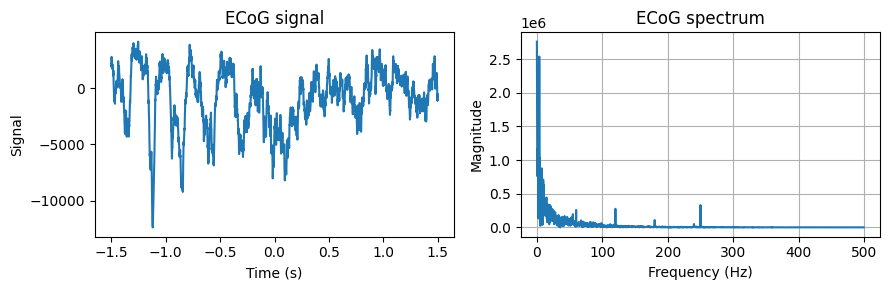

In [42]:
# get a snippet of the ecog signal around the time of thumb flexion
thumb_flex = thumb_starts[10]
pre = 1.5
post = 1.5
window = np.arange(thumb_flex-int(fs*pre), thumb_flex+int(fs*post))
ecog_snip = ecog[window, 20]

# calculate the DFT of the ecog signal
Y_ecog = np.fft.fft(ecog_snip)
f_ecog = np.fft.fftfreq(len(Y_ecog), 1/fs)
nyq_ind = np.argmin(np.abs(f_ecog-fs/2))

# plot the DFT
fig, ax = plt.subplots(1,2,figsize=(9, 3))
ax[0].plot(np.linspace(-pre, post, len(ecog_snip)), ecog_snip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal')
ax[0].set_title('ECoG signal')
ax[1].plot(f_ecog[:nyq_ind], np.abs(Y_ecog[:nyq_ind]))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('ECoG spectrum')
ax[1].grid()
fig.tight_layout()

We can see a few prominent features here. The spectral power decreases dramatically from low to high. Most of the spectral power seems to be below 100 Hz. There are also sharp peaks evident at a few frequencies above 100 Hz. We are visualizing the spectrum on a linear scale, both the x- and y-axes increase in values from the origin at a steady rate. However, the spectrum of brain signals is often best visualized with axes on a logarithmic scale, where values increase as powers of 10. This effectively stretches out lower values and compresses higher values. Referrred to as a 'log-log' plot, here is one for the spectrum above.

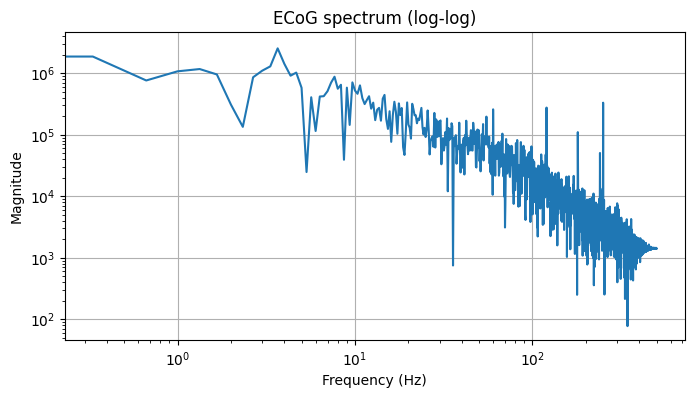

In [43]:
# log-log plot of power spectrum
fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(f_ecog[:nyq_ind], np.abs(Y_ecog[:nyq_ind]))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('ECoG spectrum (log-log)')
ax.grid()


Here we can see that on a log-log scale the ECoG spectrum seems to decrease linearly. This is characteristic of the spectrums for many natural proceses, including brain signals. However, where is the decrease in low frequency and increase in high frequency power during the movement? Recall that these changes were constrained to the finger flexion event, while our window is 3 seconds around that time.

One way to overcome this is to make our window shorter, from 3 seconds down to 250 ms. This will lower our frequency resolution, from 1/3s = 0.3 Hz to 1/0.2s = 4 Hz. How does this spectrum look?

In [44]:
thumb_flex = thumb_starts[10]
pre = 0.125
post = 0.125
window = np.arange(thumb_flex-int(fs*pre), thumb_flex+int(fs*post))
ecog_win = ecog[window, 20]

# calculate the DFT of the ecog signal
Y_win = np.fft.fft(ecog_win)
f_win = np.fft.fftfreq(len(Y_win), 1/fs)

nyq_ind = np.argmin(np.abs(f_win-fs/2))
# plot the DFT
fig, ax = plt.subplots(1,2,figsize=(9, 3))
ax[0].plot(np.linspace(-pre, post, len(ecog_win)), ecog_win)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal')
ax[0].set_title('ECoG signal')
ax[1].loglog(f_win[:nyq_ind], np.abs(Y_win[:nyq_ind]))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('ECoG spectrum')
ax[1].grid()
fig.tight_layout()

The spectrum has lost some of its frequency resolution, the comprise we have to pay for a shorter window. Something to be careful about when taking such short windows is that spectral leakage can occur when the start and end values of the window are different. This is the case with the window above, where the starting value is near 0, but the ending value is around -4000. A fundamental assumption of spectral analysis is that the signal we apply it to is periodic, that it repeats over and over. If we stacked these windows together, you would see a sharp transition between repeats. Spectrally, this manifests as a spurious broad increase in power.

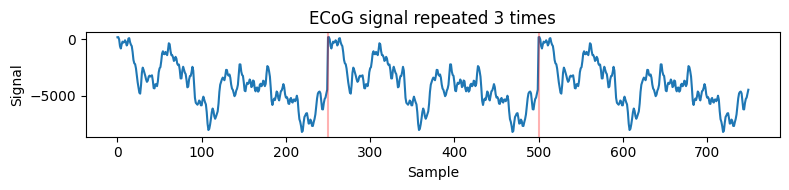

In [45]:
# plot ecog_win signal repeated 3 times
plt.figure(figsize=(8, 2))
plt.plot(np.tile(ecog_win, 3))
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.title('ECoG signal repeated 3 times')
# draw faded line at each repeat
for i in range(1, 3):
    plt.axvline(i*len(ecog_win), color='r', alpha=0.3)
plt.tight_layout()


Note the sharp step where the red lines are. To reduce this, a *windowing function* is applied to force the edges of the signal in the window towards zero. These are often bell shaped, peaking at the middle of the window. The one we will use is the Hann widnow, described by the function:

$$w(n) = 0.5 - 0.5 \cos\left(\frac{2\pi n}{N-1}\right)$$

In this notation, $n$ is the index of the sample in the window, $N$ is the total number of samples in the window.

As always, let's first try coding it ourselves and then apply it to our windowed ECoG. Here is how it looks and its effect on a data snippet.

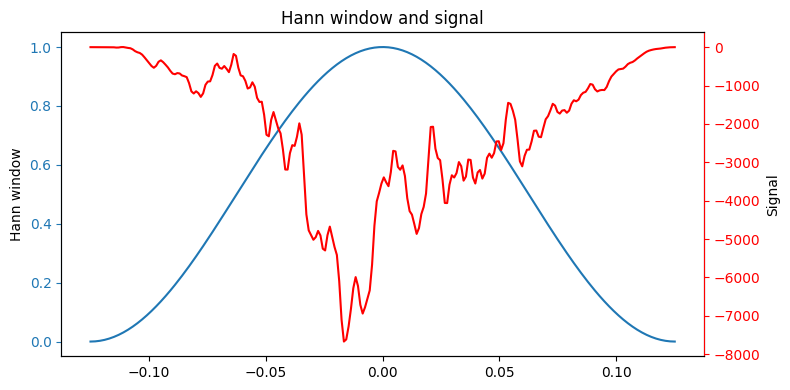

In [46]:
def hann(N):
    """
    Calculates the Hann window.
    
    Parameters
    ----------
    N : int
        The length of the window.
    
    Returns
    -------
    w : array_like
        The Hann window.
    """
    n = np.arange(N)
    w = 0.5 - 0.5*np.cos(2*np.pi*n/(N-1))
    return w

hann_win = hann(len(ecog_win))

# plot the Hann window and ecog_win signal windowed on same axis with different y axes
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(-pre, post, len(ecog_win)), hann_win)
plt.gca().spines['left'].set_color('tab:blue')
plt.gca().tick_params(axis='y', colors='tab:blue')
plt.ylabel('Hann window')
plt.twinx()
plt.plot(np.linspace(-pre, post, len(ecog_win)), ecog_win*hann_win, color='r')
plt.gca().spines['right'].set_color('r')
plt.gca().tick_params(axis='y', colors='r')
plt.ylabel('Signal')
plt.title('Hann window and signal')
plt.tight_layout()

Now the edges of the window both are at 0, so we no longer have the step How does the Hann window affect the spectrum? Instead of using our scratch built Hann function, we will use the ones from the scipy signals package. It offers a wide variety of [windowing functions](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows).

Note that if we do not apply an explicit windowing function, we are using a 'Rectangular' window, where the all values in the signal are multiplied by 1 inside the window interval.

In [47]:
# get hamming window
win = hann(len(ecog_win))

# window ecog_snip
ecog_hann = ecog_win*win

# fft of windowed ecog_snip
Y_hann = np.fft.fft(ecog_hann)
f_hann = np.fft.fftfreq(len(Y_hann), 1/fs)

nyq_ind_hann = np.argmin(np.abs(f_hann-fs/2))

# plot the DFT
fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(f_hann[:nyq_ind_hann], np.abs(Y_hann[:nyq_ind_hann]), label='Hann window')
ax.loglog(f_win[:nyq_ind_hann], np.abs(Y_win[:nyq_ind_hann]), label='Rectangular window')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('ECoG spectrum, windowed')
ax.legend()
ax.grid()
fig.tight_layout()

The windowing function has reduced the power at higher frequencies, which are where the spectral leakage should be most prominent since a sharp transition from -4000 to 0 would be high frequency.

Now we want to apply our spectral analysis across the entire recording. For this we will move our window from the start to the end, stepping along at a fixed interval less than our window duration. At each spot we will apply the windowing function and calculate the FFT.

In [48]:
def specgram(y, window=0.25, step=0.05, fs=1000):
    """
    Calculates the spectrogram of a signal.

    Parameters
    ----------
    y : array_like
        The signal to calculate the spectrogram for.
    window : float
        The length of the window in seconds.
    step : float
        The step size in seconds.
    fs : float
        The sampling rate of the signal.

    Returns
    -------
    freqs : array_like
        The frequency vector.
    t : array_like
        The time vector.
    Y : array_like, complex
        The spectrogram. We cutoff at the Nyquist frequency.
    """

    # calculate the window size and step size in samples
    win_size = int(window*fs)
    step_size = int(step*fs)
    nyq_ind = int(win_size/2)

    # calculate the number of steps
    n_steps = int((len(y)-win_size)/step_size)

    # calculate the time at the center of each window
    t = (np.arange(n_steps)*step)+(window/2)

    # calculate the frequency vector
    freqs = (np.arange(nyq_ind)/win_size)*fs

    # initialize the spectrogram matrix
    Y = np.zeros((nyq_ind, n_steps), dtype=complex)

    # calculate hann window
    win = hann(win_size)

    # calculate the spectrogram
    for i in range(n_steps):
        Y[:, i] = np.fft.fft(y[(i*step_size):(i*step_size+win_size)]*win)[:nyq_ind]
    return freqs, t, Y

To evaluate our `specgram` function, we will compare it with the `spectrogram` function in the SciPy package. The SciPy version has a few differences from ours. It allows you to specify the type of windowing function, including the Hann window. The size of the window, `nperseg` is given in terms of samples, instead of seconds. To set the sample window size, multiply the window duration in seconds by the sample rate, and then convert to an integer. Lastly, instead of specifying the step size, the SciPy version takes a `noverlap` argument, which is the number of samples shared between adjacent windows. The step size will be equal to `nperseg` - `noverlap`. Lastly, it returns only the spectral power (a real number), and not the phase/amplitude (a complex number).

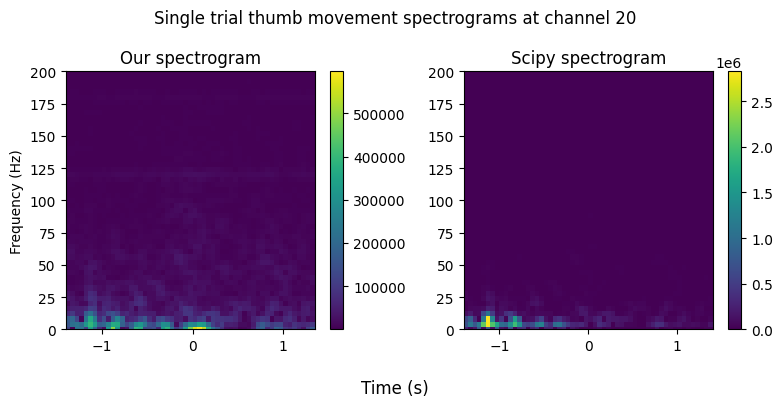

In [49]:
# calculate the spectrogram of the ecog signal
freqs_ours, t_ours, Y_ours = specgram(ecog_snip)

win_size = int(0.25*fs)
ovlap_size = int(0.2*fs) # 250 ms - 200 ms = 50 ms step
freqs_sp, t_sp, Y_sp = spectrogram(ecog_snip, fs=fs, window='hann', nperseg=win_size, noverlap=ovlap_size)

# plot the spectrogram
fig, ax = plt.subplots(1,2,figsize=(8, 4))
pc1 = ax[0].pcolormesh(t_ours-1.5, freqs_ours, np.abs(Y_ours))
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Our spectrogram')
plt.colorbar(pc1, ax=ax[0])
ax[0].set_ylim([0, 200])
pc2 = ax[1].pcolormesh(t_sp-1.5, freqs_sp, np.abs(Y_sp))
ax[1].set_title('Scipy spectrogram')
ax[1].set_ylim([0, 200])
plt.colorbar(pc2, ax=ax[1])
fig.suptitle('Single trial thumb movement spectrograms at channel 20')
fig.supxlabel('Time (s)')
fig.tight_layout()

They are mostly similar, but the spectral power is much higher for the Scipy version. This is because instead of just returning the normal FFT output, it squares and divides the power by the frequency. This converts to power spectral density.  We can put this mathematically as:

$$ PSD = \frac{S_{xx}^2}{Freq} $$

It is difficult to see other differences in the spectrograms, since the power falls off so dramatically as frequency increases. To compensate for this, we can take the z-score across time for each frequency. This will place the power fluctuations at each frequency on the same scale.

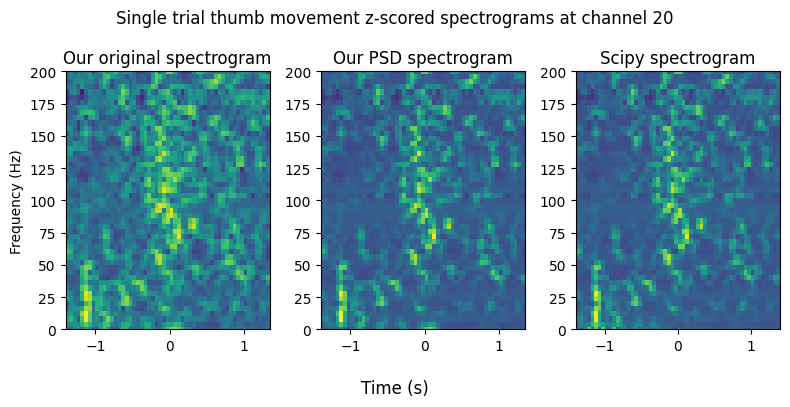

In [50]:
# convert our spectrogram amplitude to PSD, just like scipy does

def amp2psd(Y, freqs):
    """
    Converts a complex spectrogram to power spectral density

    Parameters
    ----------
    Y : array_like, complex
        The spectrogram.
    freqs : array_like
        The frequency vector.

    Returns
    -------
    Y_psd : array_like
        The power spectral density.
    """

    # add minimum float to freqs to avoid divide by zero
    # reshape freqs to be a column vector for broadcasting
    freqs_fixed = freqs.reshape(-1,1)+np.finfo(float).eps
    Y_psd = np.abs((Y/freqs_fixed)**2)
    return Y_psd

Y_ours_psd = amp2psd(Y_ours, freqs_ours)

# convert to z-scored power
Y_ours_z = zscore(np.abs(Y_ours), axis=1)
Y_ours_psd_z = zscore(Y_ours_psd, axis=1)
Y_sp_z = zscore(Y_sp, axis=1)

# plot the spectrogram
fig, ax = plt.subplots(1,3,figsize=(8, 4))
ax[0].pcolormesh(t_ours-1.5, freqs_ours, Y_ours_z)
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Our original spectrogram')
ax[0].set_ylim([0, 200])
ax[1].pcolormesh(t_ours-1.5, freqs_ours, Y_ours_psd_z)
ax[1].set_title('Our PSD spectrogram')
ax[1].set_ylim([0, 200])
ax[2].pcolormesh(t_sp-1.5, freqs_sp, Y_sp_z)
ax[2].set_title('Scipy spectrogram')
ax[2].set_ylim([0, 200])
fig.suptitle('Single trial thumb movement z-scored spectrograms at channel 20')
fig.supxlabel('Time (s)')
fig.tight_layout()


The results are quite similar. Both show a burst of high frequency activity at time zero, when movement onset occurs. Note, however, that the 'background' activity in our original spectrogram seems a bit higher than the one from Scipy. Background is the 'noise' or part of the signal that we are not concerned with, here the activity that is not the high frequency bursts around time 0 seconds. This is because the Scipy output returns power density, which squares the spectral output. That has the effect of increasing large spectral values (bursts) more than lower values (background). If we apply the same transform to ours, we get a nearly identical spectrogram.

## Evoked and induced brain activity

When we analyzed ERPs, we took the average neural response to a stimulus across trials. The ERP emerged from this analysis because the activity of the brain driven by the stimulus had a reliable time course following the stimulus. Averaging across trials would reinforce this response, while activities that are not time-locked cancel out because they are equally likely to have positive or negative values at every time point. This is referrred to as the *evoked response*.

Alternatively, if we subtract the evoked response from each trial, calculate their spectrograms, and then average those spectrograms, we get the *induced response*. This captures the activities that are not time-locked to the stimulus. The high frequency bursts associated with movements are induced activities.

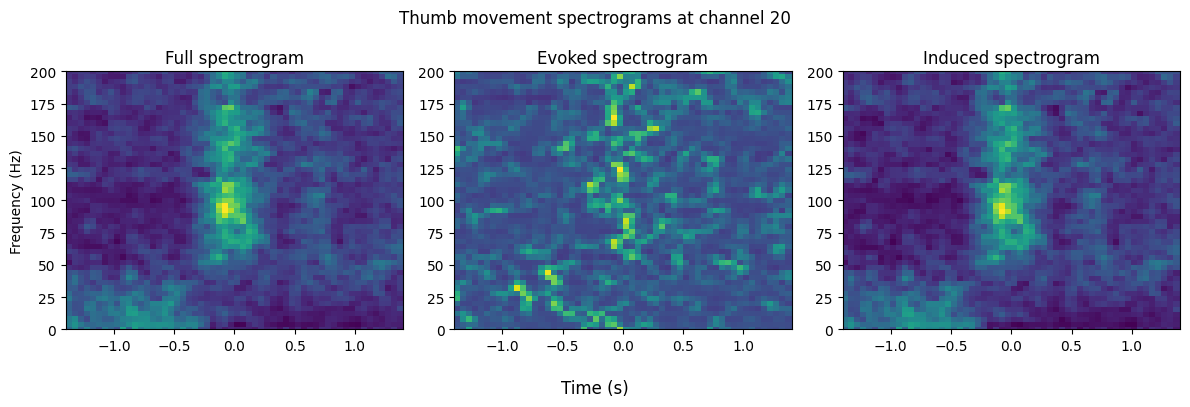

In [51]:
# snippets of thumb movement periods
thumb_flex = thumb_starts[10]
pre = 1.5
post = 1.5
window = np.arange(-int(fs*pre), int(fs*post))
ecog_win = np.vstack([ecog[window+x,20] for x in thumb_starts])

# calculate full spectrogram for thumb movement
for i in range(ecog_win.shape[0]):
    freqs, t, Y = spectrogram(ecog_win[i,:], fs=fs, window='hann', nperseg=win_size, noverlap=ovlap_size)
    if i == 0:
        Y_all = np.zeros((ecog_win.shape[0], Y.shape[0], Y.shape[1]))
    Y_all[i,:,:] = Y
Y_full = np.mean(zscore(Y_all,axis=2), axis=0)


# calculate evoked spectrogram
erp = np.mean(ecog_win, axis=0)
freqs, t, Y_ev = spectrogram(erp, fs=fs, window='hann', nperseg=win_size, noverlap=ovlap_size)
Y_ev = zscore(Y_ev, axis=1)

# calculate induced spectrogram
ecog_ind = ecog_win - erp
for i in range(ecog_ind.shape[0]):
    freqs, t, Y = spectrogram(ecog_ind[i,:], fs=fs, window='hann', nperseg=win_size, noverlap=ovlap_size)
    if i == 0:
        Y_all = np.zeros((ecog_ind.shape[0], Y.shape[0], Y.shape[1]))
    Y_all[i,:,:] = Y
Y_ind = np.mean(zscore(Y_all,axis=2), axis=0)

# plot the spectrograms
fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].pcolormesh(t-1.5, freqs, Y_full)
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Full spectrogram')
ax[0].set_ylim([0, 200])
ax[1].pcolormesh(t-1.5, freqs, Y_ev)
ax[1].set_title('Evoked spectrogram')
ax[1].set_ylim([0, 200])
ax[2].pcolor(t-1.5, freqs, Y_ind)
ax[2].set_title('Induced spectrogram')
ax[2].set_ylim([0, 200])
fig.suptitle('Thumb movement spectrograms at channel 20')
fig.supxlabel('Time (s)')
fig.tight_layout()

## Create a loader for ECoG finger data
We will keep returning to this finger movement data in the subsequent lectures, so let's create a class for interacting with it. It will feature do much of what we covered in this lecture:
1. Load the data from the mat file (`__init__`)
2. Identify finger flexions and their onsets (`detect_flex_events` and `detect_flex_onsets`)
3. Calculate and return epochs as spectrograms (`get_spec`)
4. Return epochs as time series (`get_sig`)
5. Plot ECoG grid data (`plot_ecog_surf` and `plot_ecog_data`)

In [52]:
class EcogFingerData():
    def __init__(self, fpath, fs=1000, finger_lut=None, spec_win=0.25, spec_step=0.05):
        """
        Loads ECoG finger data.

        Parameters
        ----------
        fpath : str
            Path to data file
        fs : float
            Sampling rate of data
        finger_lut : dict
            Dictionary mapping finger names to indices
        spec_win : float
            Window length for spectrogram in seconds
        spec_step : float
            Step size for spectrogram in seconds
        """

        self.fpath = fpath
        self.fs = fs
        
        if finger_lut is None:
            self.finger_lut = {'thumb':0, 'index':1, 'middle':2, 'ring':3, 'little':4}
        else:
            self.finger_lut = finger_lut
        
        data = loadmat(fpath)
        self.ecog = data['data'].T # channels x time
        self.regions = data['elec_regions']
        self.flex = data['flex'].T # fingers x time
        self.brain = data['brain']
        self.locs = data['locs']
        self.cue = data['cue']
        self._ch_num = self.ecog.shape[0]

        # calculate spectrogram
        win_len = int(spec_win*fs)
        overlap_len = int((spec_win-spec_step)*fs) # E.g. 250 ms - 50 ms = 200 ms overlap
        spec_temp = []
        for i in range(self._ch_num):
            f, t, s = spectrogram(self.ecog[i,:], fs=self.fs, window='hann', nperseg=win_len, noverlap=overlap_len)
            spec_temp.append(s)

        self.spec = np.stack(spec_temp, axis=0) # channels x freq x time
        self.spec_fs = 1/np.mean(np.diff(t)) # calculate spectrogram sampling rate
        self.spec_f = f
        self.spec_t = t

    def get_sig(self, chans=None, event_times=None, pre_t=None, post_t=None):
        """
        Gets a signal from the data.
        
        Parameters
        ----------
        chans : array_like
            Array of channels to get signal from. If None, all channels will be used.
        event_times : array_like
            Array of event times. If None, all times will be used.
        pre_t : float
            Time before event to include in signal (in seconds). Default is 0.
        post_t : float
            Time after event to include in signal (in seconds)
            
        Returns
        -------
        rel_t : array_like
            Array of times relative to event.
        sig : array_like
            Array of signal. Will have one additional dimension appended to the beginning,
            corresponding to the epoch number.
        """
        
        if chans is None: # if no channels specified, use all
            chans = np.arange(self._ch_num).flatten()
        else:
            chans = np.array(chans).flatten()
        
        if event_times is None: # if no event times specified, use entire session
            event_idxs = int(0)
            pre_len = int(0)
            post_len = self.ecog.shape[1]
        else:
            event_idxs = np.round(event_times*self.fs).astype(int)

        if pre_t is None: # if no pre time specified, start at event time
            pre_len = int(0)
        else:
            pre_len = np.round(pre_t*self.fs).astype(int)
        
        if post_t is None: # if no post time specified, use single time sample
            post_len = 1
        else:
            post_len = np.round(post_t*self.fs).astype(int)

        rel_idxs, sig = epoch_data(self.ecog[chans,:], event_idxs=event_idxs, 
                          pre_len=pre_len, post_len=post_len)

        rel_t = rel_idxs/self.fs
        return rel_t, sig
    
    def get_spec(self, chans=None, freq_min=None, freq_max=None, event_ts=None, pre_t=None, post_t=None):
        """
        Gets a spectrogram from the data.
        
        Parameters
        ----------
        chans : array_like
            Array of channels to get signal from. If None, all channels will be used.
        freq_min : float
            Minimum frequency to include in spectrogram
        freq_max : float
            Maximum frequency to include in spectrogram
        event_ts : array_like
            Array of event times in seconds. If None, entire session is returned
        pre_t : float
            Time before event to include in signal (in seconds). Default is 0.
        post_t : float
            Time after event to include in signal (in seconds). Default is None, which
            returns a single time sample at event_times.

            
        Returns
        -------
        f : array_like
            Array of frequencies.
        rel_t : array_like
            Array of times relative to event.
        spec : array_like
            Array of spectrogram. Will have one additional dimension appended to the beginning,
            corresponding to the epoch number.
        """
        

        if chans is None: # if no channels specified, use all
            chans = np.arange(self._ch_num).flatten()
        else: # otherwise convert, or ensure, it is a numpy array
            chans = np.array(chans).flatten()

        if freq_min is None: # if no min frequency specified, use lowest
            freq_min_idx = 0
        else:
            freq_min_idx = np.where(self.spec_f >= freq_min)[0][0]


        if freq_max is None: # if no max frequency specified, use highest
            freq_max_idx = len(self.spec_f) 
        else:
            freq_max_idx = np.where(self.spec_f <= freq_max)[0][-1]

        if event_ts is None: # if no event times specified, use entire session
            event_idxs = int(0)
            pre_len = int(0)
            post_len = self.spec.shape[2]
        else:
            # get differences between event times and spectrogram times
            event_diffs = np.abs(event_ts.reshape(-1,1) - self.spec_t.reshape(1,-1))
            # get indices of event times in spectrogram
            event_idxs = np.argmin(event_diffs, axis=1)

        if post_t is None: # if no post time specified, use single time sample
            post_len = 1
        else:
            post_len = int(post_t*self.spec_fs)

        if pre_t is None: # if no pre time specified, start at event time
            pre_len = 0
        else:
            pre_len = int(pre_t*self.spec_fs)
        
        rel_idxs, spec = epoch_data(self.spec[chans, freq_min_idx:freq_max_idx, :], event_idxs=event_idxs,
                            pre_len=pre_len, post_len=post_len)

        f = self.spec_f[freq_min_idx:freq_max_idx]
        rel_t = rel_idxs/self.spec_fs

        return f, rel_t, spec

    
    def detect_flex_events(self, thresh=1.5, min_duration=500, max_spacing=500):
        """
        Detects events in a flex signal.
        
        Parameters
        ----------
        thresh : float
            The threshold to use for event detection.
        min_duration : int
            The minimum duration of an event (in samples).
        max_spacing : int
            The maximum spacing between events (in samples).
            
        Returns
        -------
        events : array_like
            Binary array.
        """

        # 1. get the z-scored flex signal
        z_sig = zscore(self.flex, axis=1)

        # 2. detect when signal crosses a threshold
        events = z_sig > thresh

        # 3. combine events spaced too closely together
        events = sn.binary_closing(events, structure=np.ones([1,max_spacing]))

        # 4. remove events shorter than min duration
        events = sn.binary_opening(events, structure=np.ones([1,min_duration]))
        
        # 5. for each flexion epoch, keep only the channel with the largest amplitude
        epochs = np.any(events, axis=0).astype(int)
        epochs = np.concatenate(([0], epochs, [0])) # pad with False
        onsets = np.where(np.diff(epochs) == 1)[0]+1
        offsets = np.where(np.diff(epochs) == -1)[0]+1

        for onset, offset in zip(onsets, offsets):
            max_chan = np.argmax(np.mean(z_sig[:,onset:offset], axis=1))
            events[:, onset:offset] = 0
            events[max_chan, onset:offset] = 1

        return events.astype(int) # convert to int for numpy operations

    def detect_flex_onsets(self, finger='thumb', **kwargs):
        """
        Detects the onsets of flex events.
        
        Parameters
        ----------
        finger : str
            Finger to detect onsets for. Must be one of 'thumb', 'index', 'middle', 'ring', 'little'.
        **kwargs : dict
            Keyword arguments to pass to detect_flex_events
            
        Returns
        -------
        onsets : array_like
            Array of flex event onsets (in seconds).
        """

        events = self.detect_flex_events(**kwargs)
        finger_ind = self.finger_lut[finger]
        onsets = np.where(np.diff(events[finger_ind,:]) == 1)[0] + 1
        return onsets/self.fs
    
    def plot_ecog_surf(self):
        """
        Plots the electrode locations on a brain.
        """

        view = plotting.view_markers(utils.tal2mni(self.locs),
                                     marker_labels=['%d'%k for k in np.arange(self.locs.shape[0])],
                                     marker_color='purple',
                                     marker_size=5)
        return view
    
    def plot_ecog_data(self, data, ax=None, **kwargs):
        """
        Plots the electrode locations on a brain.

        Parameters
        ----------
        data : array_like
            Array of data to plot. Must have one row per electrode.
        ax : matplotlib axis, optional
            Axis on which to plot
        **kwargs : optional
            Additional keyword arguments to pass to matplotlib plot function

        Returns
        -------
        ax : matplotlib axis
            Axis on which data was plotted
        """

        if ax is None:
            ax = plt.gca()
        ax.scatter(self.locs[:, 0], self.locs[:, 1], c=data, **kwargs)
        return ax
    

Now we should test this class to make sure each of its functions works.

First we will initialize it using the same file we have been working with so far.

In [53]:
ecog_data = EcogFingerData(ecog_file)

Can we reproduce the map of the ECoG grid on the brain surface.

In [54]:
ecog_data.plot_ecog_surf()

Looks good.

Now we will detect finger flexion events. Let's get the movements of the index finger.

In [55]:
# get index finger flexion onset times
index_onsets = ecog_data.detect_flex_onsets('index')
print('Index finger onsets: {}'.format(index_onsets))

Index finger onsets: [ 19.08  57.32  64.68  72.64  75.92 108.6  160.   172.04 183.84 191.84
 204.04 211.92 232.08 239.8  247.76 251.8  271.96 287.88 299.88 303.8
 315.8  319.6  340.04 351.88 415.76 460.64 483.96 492.   523.84 543.96
 559.92 579.84]


Let's get the ERPs for index finger flexions. The `get_sigs` function returns the ECoG signal as a numpy array with the format epoch x channel x time.

Text(0.5, 1.0, 'Index finger ERP')

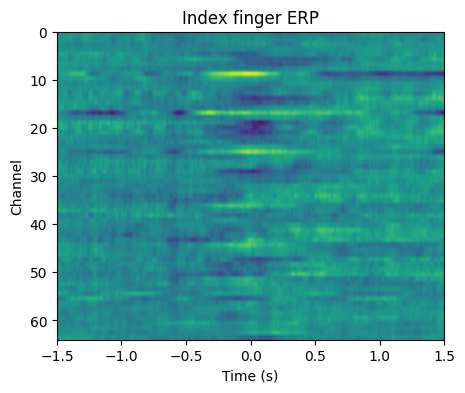

In [56]:
rel_t_sig, index_sigs = ecog_data.get_sig(event_times=index_onsets, pre_t=1.5, post_t=1.5)
chans = np.arange(index_sigs.shape[1])
# calculate ERP by averaging over epochs
index_erp = np.mean(index_sigs, axis=0).squeeze()

# plot the ERP
plt.figure(figsize=(5, 4))
plt.imshow(index_erp, aspect='auto', extent=[-1.5, 1.5, 64, 0])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Index finger ERP')

Now let's check out the spectrograms surrounding index finger movements. We will plot just a few channels based on those with distinctive ERPs. Channel 9 with a strong positivity, 19 with a strong negativity, and 61 with nothing noticable.

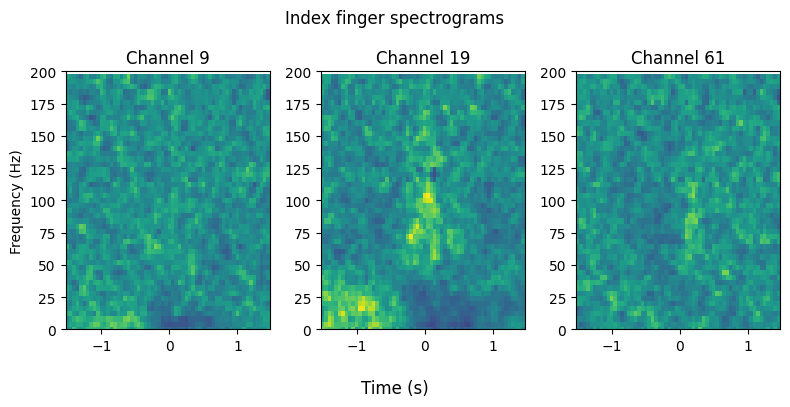

In [57]:
# calculate the event-related spectrogram for channels 9, 19, and 61
f, rel_t_spec, index_spec = ecog_data.get_spec(event_ts=index_onsets, chans=[9,19,61], pre_t=1.5, post_t=1.5, freq_max=200)

# calculate the z-scored spectrogram
index_spec_z = np.mean(zscore(index_spec,axis=3), axis=0)
max_z = np.max(np.abs(index_spec_z))

# plot the spectrograms
fig, ax = plt.subplots(1,3,figsize=(8, 4))
ax[0].pcolormesh(rel_t_spec, f, index_spec_z[0,:,:], vmin=-max_z, vmax=max_z)
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Channel 9')
ax[0].set_ylim([0, 200])
ax[1].pcolormesh(rel_t_spec, f, index_spec_z[1,:,:], vmin=-max_z, vmax=max_z)
ax[1].set_title('Channel 19')
ax[1].set_ylim([0, 200])
ax[2].pcolormesh(rel_t_spec, f, index_spec_z[2,:,:], vmin=-max_z, vmax=max_z)
ax[2].set_title('Channel 61')
ax[2].set_ylim([0, 200])
fig.suptitle('Index finger spectrograms')
fig.supxlabel('Time (s)')
fig.tight_layout()


## Code summary

In [59]:
little_sigs.shape

(29, 63, 3000)

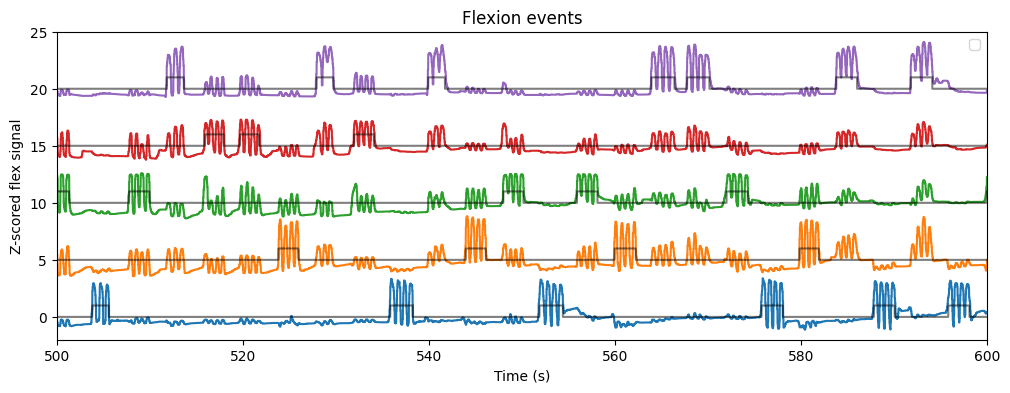

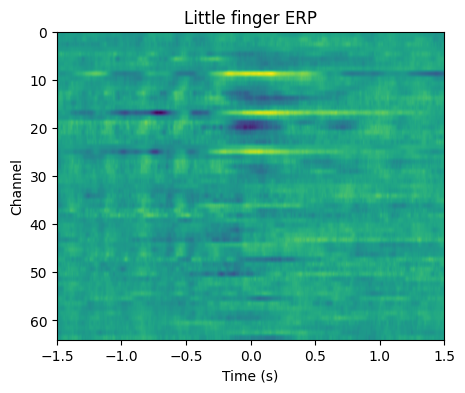

In [58]:
# load data files
subj = 'cc'
ecog_path = ['..', 'data', 'ecog', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path) # use * to unpack the list
ecog = EcogFingerData(ecog_file)

# detect flexion events, you can change the detection parameters to improve flexion detection
flex_events = ecog.detect_flex_events(thresh=1.7, min_duration=500, max_spacing=500)

# get z-scored flex signal
zflex = zscore(ecog.flex, axis=1)
t = np.arange(zflex.shape[1])/ecog.fs

# plot the events
plt.figure(figsize=(12, 4))
ax = plot_stacked_signals(zflex.T,t)
plot_stacked_signals(flex_events.T,t, ax=ax, color='k', alpha=0.5)
ax.set_xlim([500, 600])
ax.set_ylim([-2, 25])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Z-scored flex signal')
ax.set_title('Flexion events')

# detect little finger flexion onset times
little_onsets = ecog.detect_flex_onsets(finger='little', thresh=1.7, min_duration=500, max_spacing=500)

# identify channels for little finger flexion
rel_t_sig, little_sigs = ecog_data.get_sig(event_times=little_onsets, pre_t=1.5, post_t=1.5)

# calculate ERP by averaging over epochs
little_erp = np.mean(little_sigs, axis=0).squeeze()

# plot the ERPs across channels
plt.figure(figsize=(5, 4))
plt.imshow(little_erp, aspect='auto', extent=[-1.5, 1.5, 64, 0])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Little finger ERP')

# identify channel with strongest negative going ERP at time 0 relative to little finger flexion
ch_peak = np.argmin(little_erp[:, int(np.where(rel_t_sig==0)[0])])

# calculate the event-related spectrogram and plot it for the channel with the strongest negative going ERP
f, rel_t_spec, little_spec = ecog_data.get_spec(event_ts=little_onsets, pre_t=1.5, post_t=1.5, freq_max=200)

# calculate the z-scored spectrogram
little_spec_z = zscore(little_spec, axis=3)

# plot the spectrogram
fig, ax = plt.subplots(figsize=(5, 4))
pc = ax.pcolormesh(rel_t_spec, f, np.mean(little_spec_z[:,ch_peak],axis=0), vmin=-2, vmax=2)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
ax.set_title('Little finger spectrogram')
ax.set_ylim([0, 200])
fig.colorbar(pc, ax=ax)
fig.tight_layout()